# Introdução

A análise em questão trata-se de um problema referente à análise de crédito, e tem como objetivo construir um modelo de classificação que retorne a probabilidade que um cliente tem de ser enviado para análise de crédito uma vez que ele foi pré-aprovado para o empréstimo com garantia de automóvel.

O desenvolvimento da análise consistiu basicamente nas seguintes etapas:
- [Análise Exploratória de Dados (EDA)](#100)
    - [Análise dos Valores Faltantes e Cardinalidade](#110)
    - [Análise de Balanceamento dos Dados](#120)
    - [Análise das Variáveis Categóricas](#130)
    - [Análise das Variáveis Numéricas](#140)
        - [Análise da Relação Entre Variáveis Numéricas](#145)
        - [Análise de Outliers](#149)
    - [Insights da EDA](#150)
- [Preprocessamento](#200)
    - [Tratamento de Outliers](#210)
    - [Seleção de Variáveis](#220)
    - [NLP Aplicado à `informed_purpose`](#230)
    - [Train vs.Validation vs. Test Split](#240)
    - [NLP Aplicado à `informed_purpose` (Continuado)](#245)
    - [One-hot-enconding](#250)
    - [Estratégia para Imputação de Valores Faltantes](#260)
- [Modelagem](#300)
    - [Baseline Model - Dummy Classifier](#310)
    - [Métrica de Avaliação](#320)
    - [Regressão Logística](#330)
    - [Decision Tree](#340)
    - [Random Forest](#350)
    - [XGBoost](#360)
    - [Comparação dos Modelos](#370)
    - [Ajuste de Hiperparâmetros](#380)
    - [Modelo Final - Stacking Ensemble Classifier](#390)
- [Avaliação e Interpretabilidade do Modelo Final](#400)
    - [Performance](#410)
    - [Importância das Variáveis](#420)
- [Considerações Finais](#500)

In [1]:
# Importa bibliotecas necessárias
import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import warnings

from nltk.stem.snowball import SnowballStemmer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from textacy.preprocessing.remove import remove_accents
from xgboost import XGBClassifier, plot_importance

warnings.filterwarnings('ignore')

## Carregamento dos Dados

Os dados utilizados na modelagem são referentes ao arquivo `dataset.csv`, sendo que o arquivo `description.csv` refere-se ao dicionário, onde há a descrição de cada uma das variáveis do dataset utilizado para análise. Ambos estão disponíveis na pasta `data` deste repositório.

In [2]:
# Carrega datasets
df = pd.read_csv("data/dataset.csv")
description = pd.read_csv("data/description.csv", header = None)

<a id="100"></a>

# Análise Exploratória de Dados (EDA)

Primeiramente, com o intuito de se ter um melhor entendimento sobre os dados a serem utilizados na análise, foi verificado o dicionário com a descrição das variáveis e posteriormente análisado a estrutura do dataset, assim como o tipo e a distribuição das variáveis em análise.

In [3]:
# Imprime dicionario com a descrição de cada uma das variáveis do dataset em análise
pd.options.display.max_colwidth = 200
description

,0,1
0,id,Chave única de uma solicitação de cliente
1,age,Idade do cliente
2,monthly_income,Renda mensal informada pelo cliente no momento do cadastro
3,collateral_value,Valor do automóvel que será dado em garantia
4,loan_amount,Valor solicitado pelo cliente para empréstimo
5,city,Cidade do cliente
6,state,Estado do cliente
7,collateral_debt,Valor que o automovel do cliente tem de dívida (ex. Valor que ainda está financiado)
8,verified_restriction,Indica se o cliente possui alguma restrição/pendência verificada. (NA significa que não houve consulta da situação do cliente)
9,dishonored_checks,Indica se o cliente possui cheques sem fundo


Analisando o dicionário, fica claro que `sent_to_analysis` é a variável de interesse, uma vez que o objetivo consiste em construir um modelo de classificação que retorne a probabilidade que um cliente tem de ser *enviado para análise de crédito*. Vale ressaltar que uma vez que só devem ser considerados clientes já pré-aprovados para o empréstimo, `pre_approved` é uma variável importante a ser verificada.

Partindo desse entendimento, foi análisado o `dataset.csv`.

In [4]:
# Apresenta estrutura do dataset
df.shape

(35021, 32)

In [5]:
# Apresenta o tipo de cada variável
df.dtypes

id                        int64
age                     float64
monthly_income          float64
collateral_value        float64
loan_amount             float64
city                     object
state                    object
collateral_debt         float64
verified_restriction    float64
dishonored_checks         int64
expired_debts             int64
banking_debts             int64
commercial_debts          int64
protests                  int64
marital_status           object
informed_restriction    float64
loan_term               float64
monthly_payment         float64
informed_purpose         object
auto_brand               object
auto_model               object
auto_year               float64
pre_approved            float64
form_completed          float64
sent_to_analysis        float64
channel                  object
zip_code                 object
landing_page             object
landing_page_product     object
gender                   object
utm_term                 object
educatio

Observou-se então que o dataset original possui um total de 35021 observações, com 32 variáveis - sendo algumas delas numéricas e outras categóricas. Para um melhor entendimento, foram analisadas as primeiras observações do mesmo:

In [6]:
# Imprime primeiras observações do dataset
with pd.option_context('display.max_columns', None):
    print(df.head())

             id   age  monthly_income  collateral_value  loan_amount  \
0  100001025857  61.0          1300.0               NaN      10000.0   
1        173466  50.0          3500.0           40000.0      23936.0   
2        173465  31.0          2600.0           18000.0       5000.0   
3        173464  51.0          3600.0           21000.0      10000.0   
4        173463  51.0          1500.0           10000.0       8000.0   

          city state  collateral_debt  verified_restriction  \
0          NaN   NaN              NaN                   NaN   
1       Muriaé    MG              NaN                   1.0   
2        Araxá    MG          10000.0                   0.0   
3          Jaú    SP           8000.0                   1.0   
4  Veranópolis    RS              0.0                   NaN   

   dishonored_checks  expired_debts  banking_debts  commercial_debts  \
0                  0              0              0                 0   
1                  0              0         

Como observou-se a presença de clientes não pré-aprovados para o empréstimo (`pre_approved` = 0), foi feito um filtro dos dados originais.

In [7]:
# Filtra apenas os clientes que foram pré-aprovados para o empréstimo com garantia de automóvel
df_pre_approv = df[df.pre_approved == 1]

In [8]:
# Verifica se algum id aparece mais de uma vez
ids = df_pre_approv["id"]
with pd.option_context('display.max_columns', None):
    print(df_pre_approv[ids.isin(ids[ids.duplicated()])].sort_values("id"))

           id   age  monthly_income  collateral_value  loan_amount       city  \
32008  116424  39.0          3116.0           36000.0     13574.06  São Paulo   
32009  116424  39.0          3116.0           36000.0     13574.06  São Paulo   

      state  collateral_debt  verified_restriction  dishonored_checks  \
32008    SP           2502.0                   NaN                  0   
32009    SP           2502.0                   NaN                  0   

       expired_debts  banking_debts  commercial_debts  protests  \
32008              0              0                 0         0   
32009              0              0                 0         0   

      marital_status  informed_restriction  loan_term  monthly_payment  \
32008            NaN                   0.0        NaN           777.53   
32009            NaN                   0.0        NaN           777.53   

                                                    informed_purpose  \
32008  quitar carro e reparos em casa t

Como o `id 116424` aparece duplicado, foi feita também a remoção de uma de suas observações.

In [9]:
# Remove linhas duplicadas
df_pre_approv = df_pre_approv.drop_duplicates()

<a id="110"></id>

## Análise dos Valores Faltantes e Cardinalidade

Uma vez obtido o dataset de interesse, foi avaliado o tipo de cada uma das variáveis, assim como a questão de valores faltantes.

In [10]:
# Apresenta o tipo de cada variável e total de valores não nulos referentes ao dataframe com clientes pré-aprovados
df_pre_approv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14998 entries, 7 to 35019
Data columns (total 32 columns):
id                      14998 non-null int64
age                     14998 non-null float64
monthly_income          14998 non-null float64
collateral_value        14985 non-null float64
loan_amount             14998 non-null float64
city                    14990 non-null object
state                   14998 non-null object
collateral_debt         9691 non-null float64
verified_restriction    14935 non-null float64
dishonored_checks       14998 non-null int64
expired_debts           14998 non-null int64
banking_debts           14998 non-null int64
commercial_debts        14998 non-null int64
protests                14998 non-null int64
marital_status          402 non-null object
informed_restriction    14192 non-null float64
loan_term               0 non-null float64
monthly_payment         14248 non-null float64
informed_purpose        14415 non-null object
auto_brand           

A tabela a seguir apresenta os valores faltantes em percentual:

In [11]:
# Apresenta percentual de valores faltante por variável
round(df_pre_approv.isna().sum()/len(df_pre_approv) * 100, 2)

id                        0.00
age                       0.00
monthly_income            0.00
collateral_value          0.09
loan_amount               0.00
city                      0.05
state                     0.00
collateral_debt          35.38
verified_restriction      0.42
dishonored_checks         0.00
expired_debts             0.00
banking_debts             0.00
commercial_debts          0.00
protests                  0.00
marital_status           97.32
informed_restriction      5.37
loan_term               100.00
monthly_payment           5.00
informed_purpose          3.89
auto_brand                0.00
auto_model                0.01
auto_year                 0.00
pre_approved              0.00
form_completed            0.00
sent_to_analysis          0.00
channel                   3.77
zip_code                  0.00
landing_page              3.77
landing_page_product     38.04
gender                   12.62
utm_term                 68.18
education_level          19.24
dtype: f

Como pode-se ver acima, considerando apenas os clientes já pré-aprovados, obtem-se um total de 14998 observações. A variável de interesse, `sent_to_analysis`, não possui *missing values*, tratando-se assim de um problema de **supervised learning**. 

É fácil observar que diferentes variáveis possuem valores faltantes e na seção de preprocessamento será detalhado qual será a tratativa para cada um desses casos. Entretanto, é válido ressaltar que `loan_term`, `marital_status` e `utm_term` possuem alto percentual de valores faltantes.

Foi analisado também a questão de cardinalidade das variáveis categóricas:

In [12]:
# Verifica quantidade de categorias distintas por variável
df_pre_approv.select_dtypes(include = object).nunique()

city                    2212
state                     27
marital_status             6
informed_purpose        8312
auto_brand                54
auto_model              1670
channel                    9
zip_code                4387
landing_page             190
landing_page_product       7
gender                     2
utm_term                   3
education_level            9
dtype: int64

Como já era esperado, `city`, `auto_model` e `zip_code` apresentam muitas categorias distintas. Já `informed_purpose` também apresenta cardinalidade alta, porém isso se deve ao fato dos dados terem sido carregados manualmente num campo de texto livre. 

<a id="120"></id>

## Análise de Balanceamento dos Dados

In [13]:
# Verifica balanceamento da variável de interesse, `sent_to_analysis`
counts = df_pre_approv["sent_to_analysis"].value_counts()
sent_to_analysis = counts[1.0]
rejected_to_analysis = counts[0.0]
perc_sent_to_analysis = (sent_to_analysis / (sent_to_analysis + rejected_to_analysis)) * 100
perc_rejected_to_analysis = (rejected_to_analysis / (sent_to_analysis + rejected_to_analysis)) * 100
print("Dado os clientes que foram pré-aprovados para o empréstimo com garantia de automóvel:\n- {} deles foram enviados para análise de crédito ({:.3f}%) e \n- {} foram rejeitados. ({:.3f}%).".format(sent_to_analysis, perc_sent_to_analysis, rejected_to_analysis, perc_rejected_to_analysis))

Dado os clientes que foram pré-aprovados para o empréstimo com garantia de automóvel:
- 3269 deles foram enviados para análise de crédito (21.796%) e 
- 11729 foram rejeitados. (78.204%).


<a id="130"></id>

## Análise das Variáveis Categóricas

Os gráficos a seguir ilustram a relação de cada uma das variáveis categóricas (com cardinalidade razoável) com a variável resposta, `sent_to_analysis`. Cada gráfico apresenta o percentual de observações de cada categoria que foi enviado para análise, i.e.: `sent_to_analysis` = 1.

Para uma melhor visualização houve um tratamento simples das variáveis `auto_year` e `education_level`.

In [14]:
# Converte a variável `auto_year` para inteiro
df_pre_approv["auto_year"] = df_pre_approv["auto_year"].apply(np.int64)

In [15]:
# Lista categorias referentes a `education_level`
df_pre_approv["education_level"].unique()

array(['Ensino médio completo (antigo 2º grau, secundário ou colegial).',
       'Educação superior completa', nan,
       'Ensino fundamental completo (antigo 1º grau ou primário e ginasial).',
       '4ª série completa do ensino fundamental (antigo 1º grau ou primário).',
       'Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).',
       'Educação superior incompleta.',
       'Ensino médio incompleto (antigo 2º grau, secundário ou colegial).',
       'Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.',
       'Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.'],
      dtype=object)

In [16]:
# Renomeia categorias referentes a `education_level`
df_pre_approv.replace([
    'Ensino médio completo (antigo 2º grau, secundário ou colegial).',
    'Educação superior completa',
    'Ensino fundamental completo (antigo 1º grau ou primário e ginasial).',
    '4ª série completa do ensino fundamental (antigo 1º grau ou primário).',
    'Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).',
    'Educação superior incompleta.',
    'Ensino médio incompleto (antigo 2º grau, secundário ou colegial).',
    'Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.',
    'Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.'
],[
    "Ensino Médio",
    "Superior",
    "Ensino Fundamental",
    "4ª Série",
    "5ª à 8ª Série",
    "Superior Incompleto",
    "Ensino Médio Incompleto",
    "4ª Série Incompleta",
    "Analfabeto"
], inplace = True)

In [17]:
# Converte variáveis booleanas `banking_debts`, `comercial_debts`, `dishonored_checks`, 
# `expired_debts` e `protest` que estão como inteiras  para float
boolean_cols = ["banking_debts", "commercial_debts", "dishonored_checks", "expired_debts", "protests"]
df_pre_approv[boolean_cols] = df_pre_approv[boolean_cols].applymap(np.float64)

In [18]:
# Gera gráfico de barras dado uma variável categórica
def bar_plot(data, x, y, title):
    data[x] = data[x].fillna("NA")
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 6))
    sns.barplot(x = x, y = y, data = df_pre_approv)
    ax.set_ylim(0, 1)
    ax.set_xlabel(x, fontsize = 14)
    ax.set_ylabel(y + " (%)", fontsize = 14)
    ax.set_title(title, weight = 'bold', fontsize = 18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    plt.tight_layout()
    plt.show() 

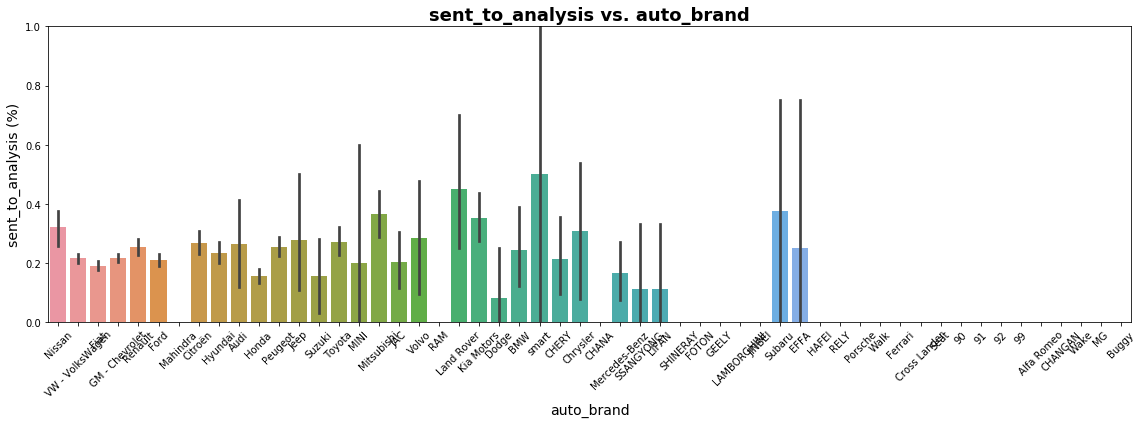

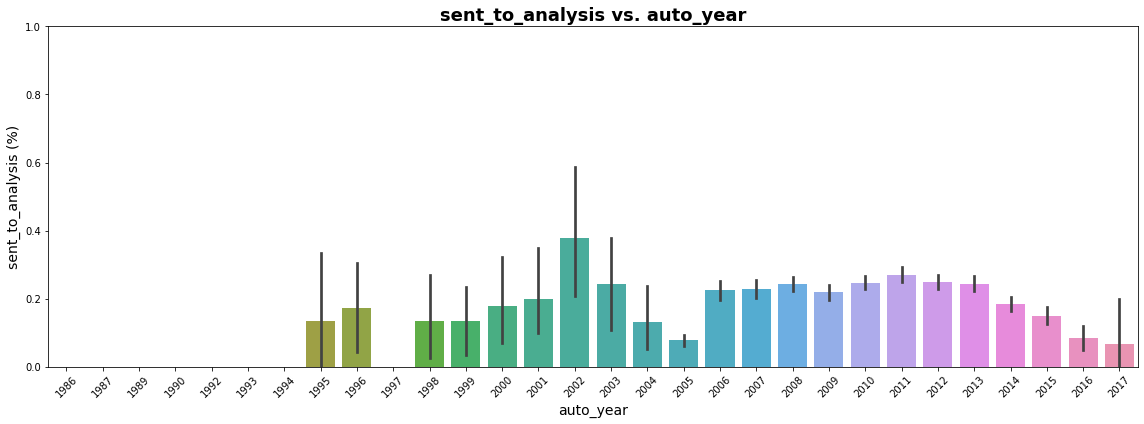

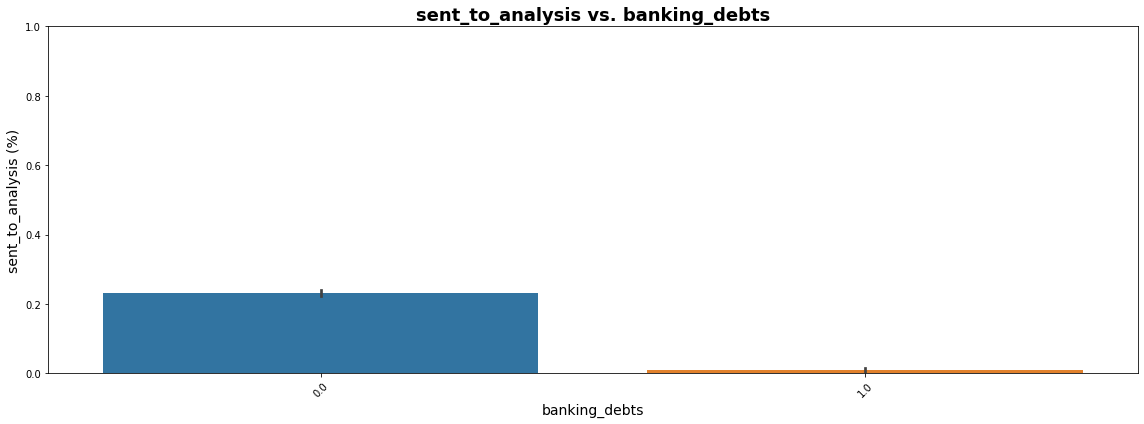

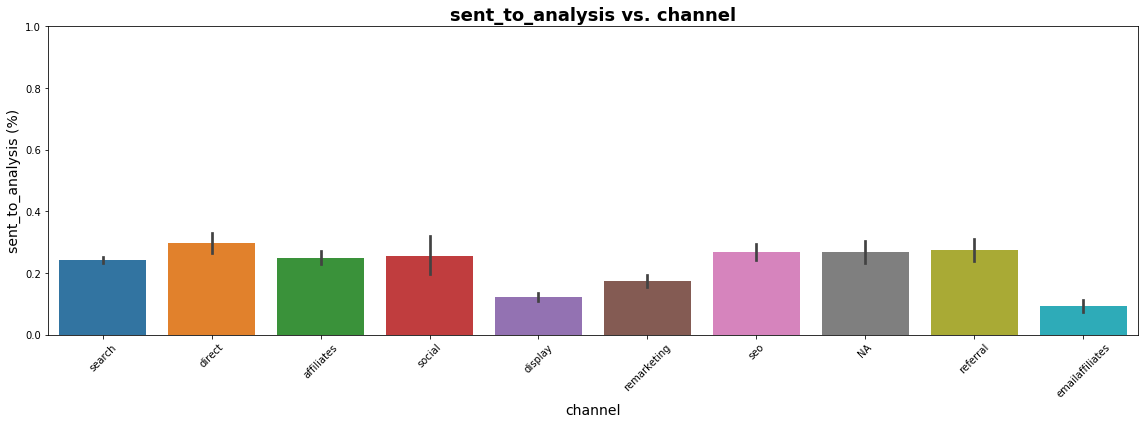

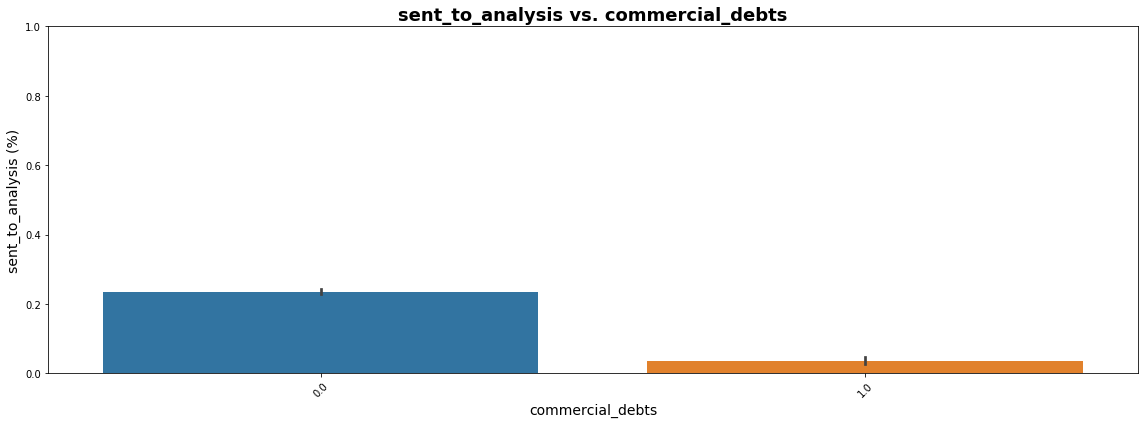

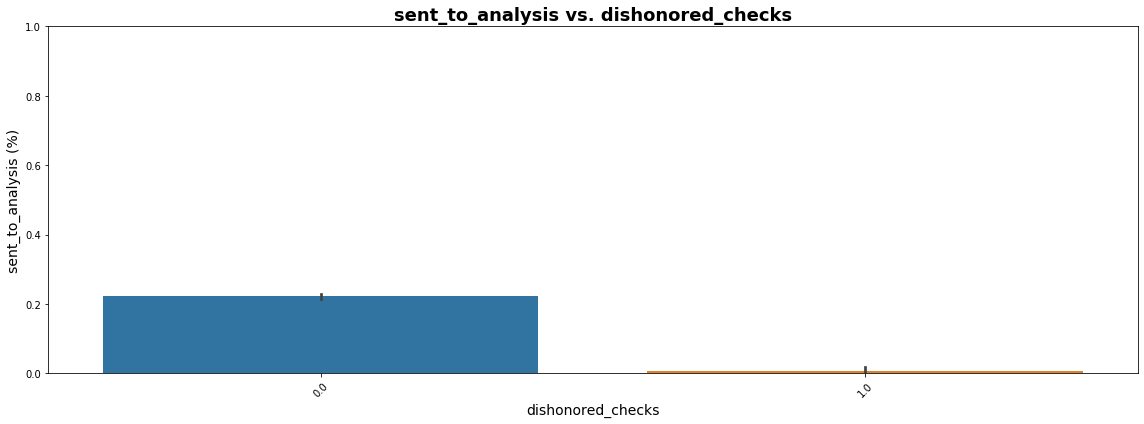

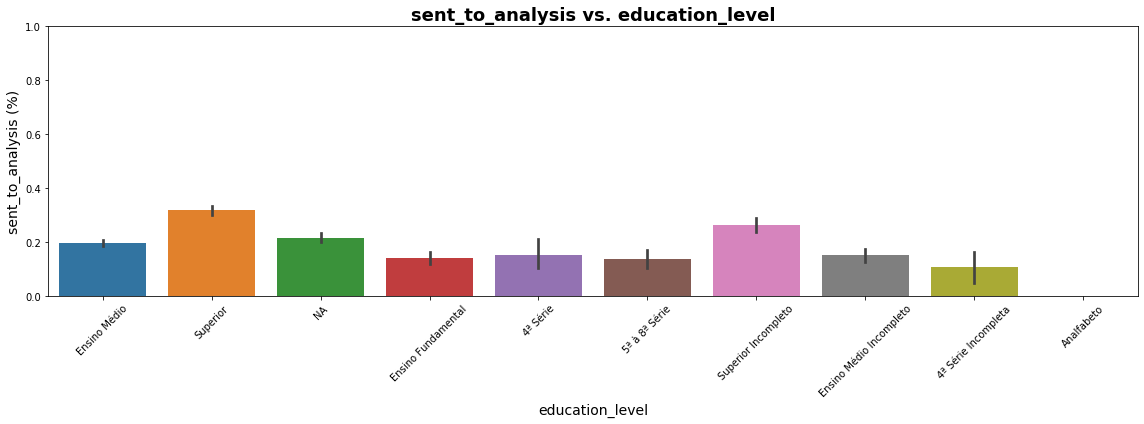

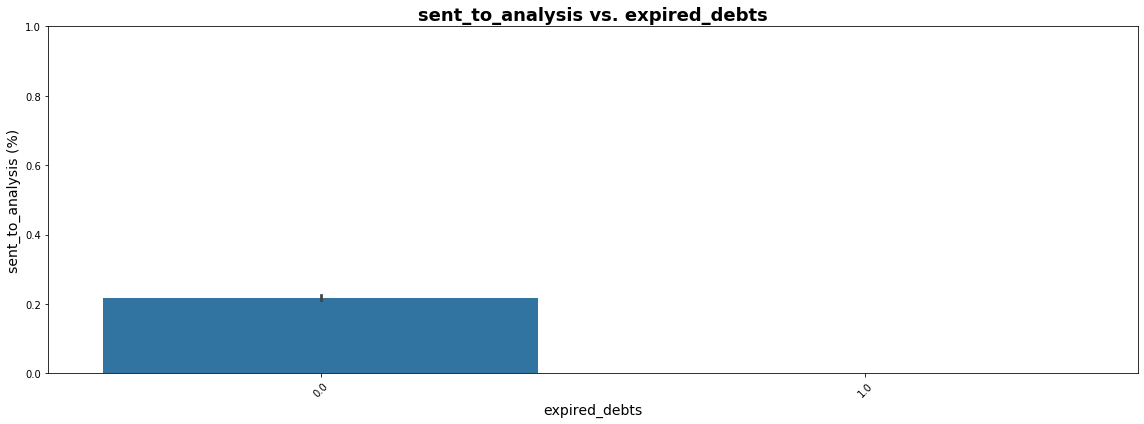

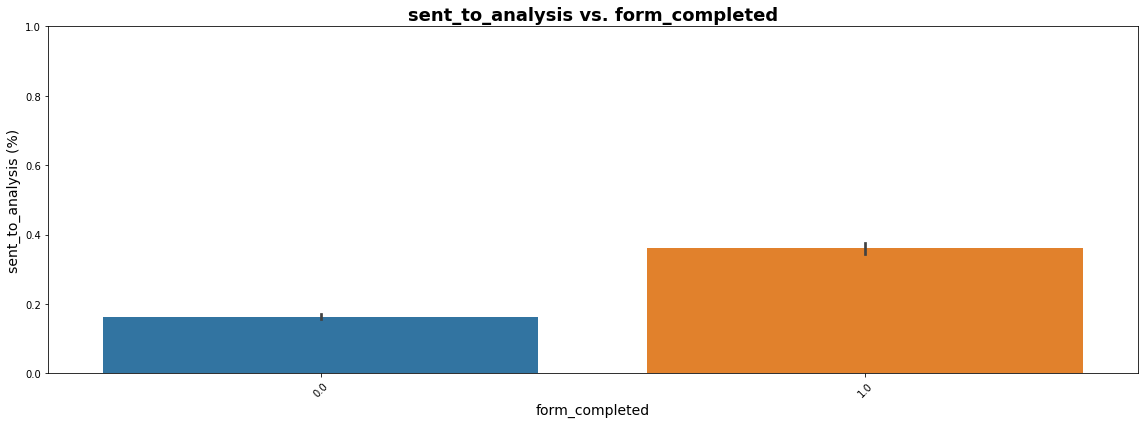

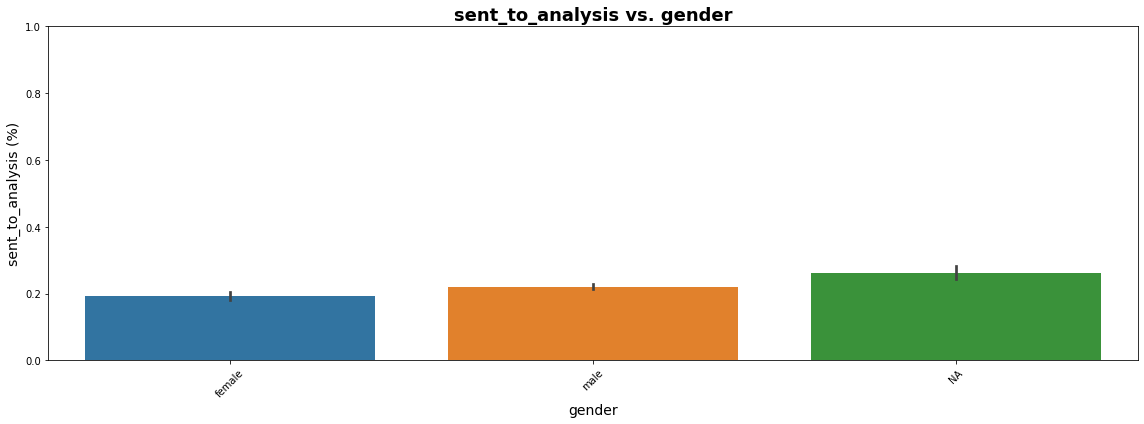

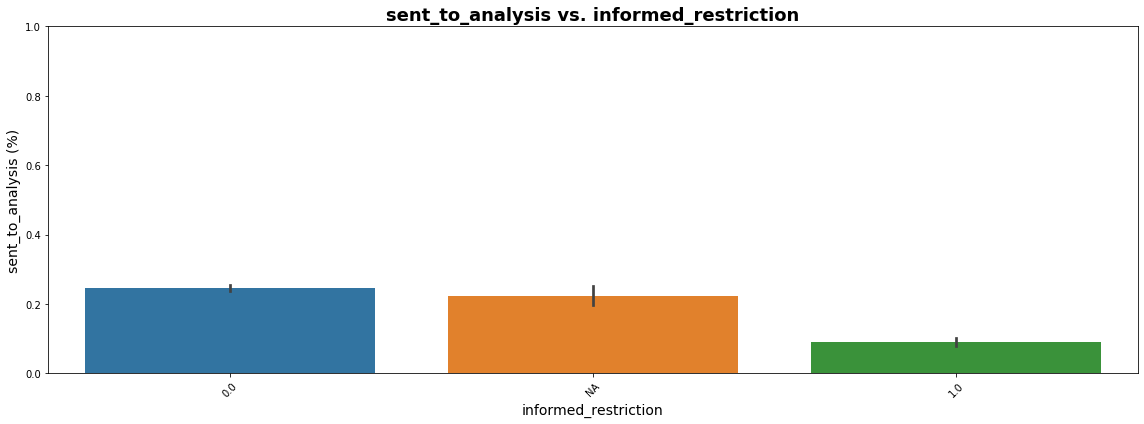

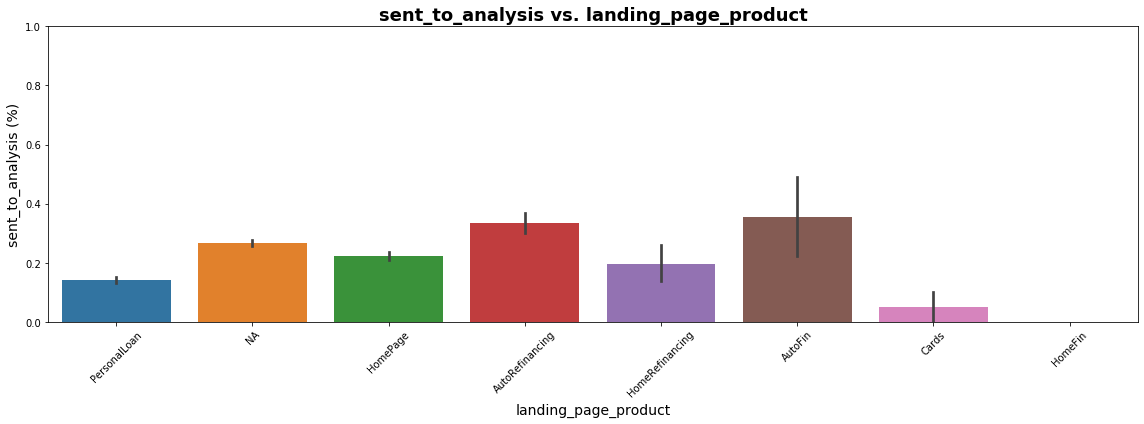

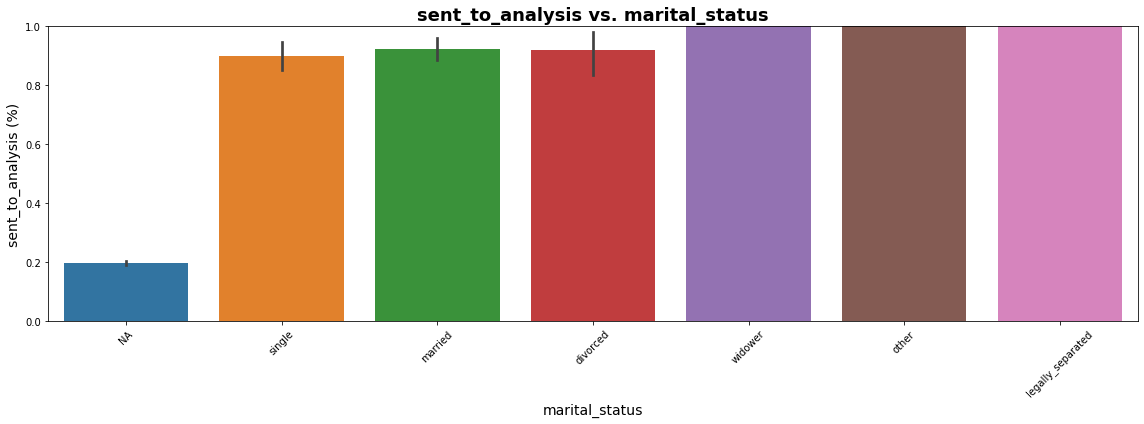

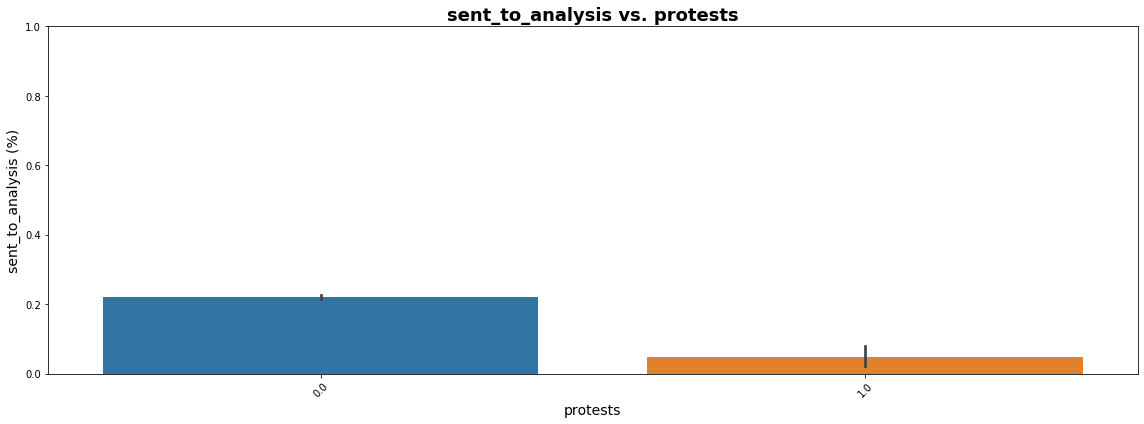

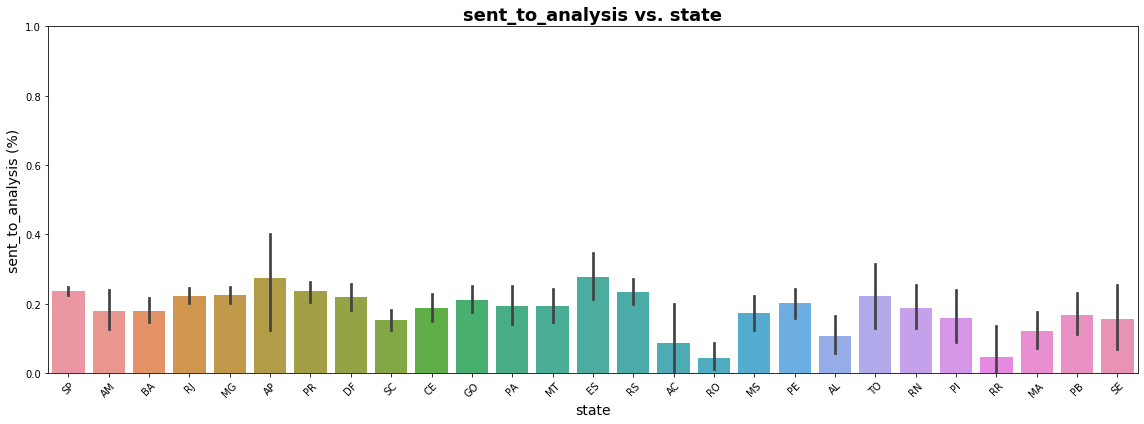

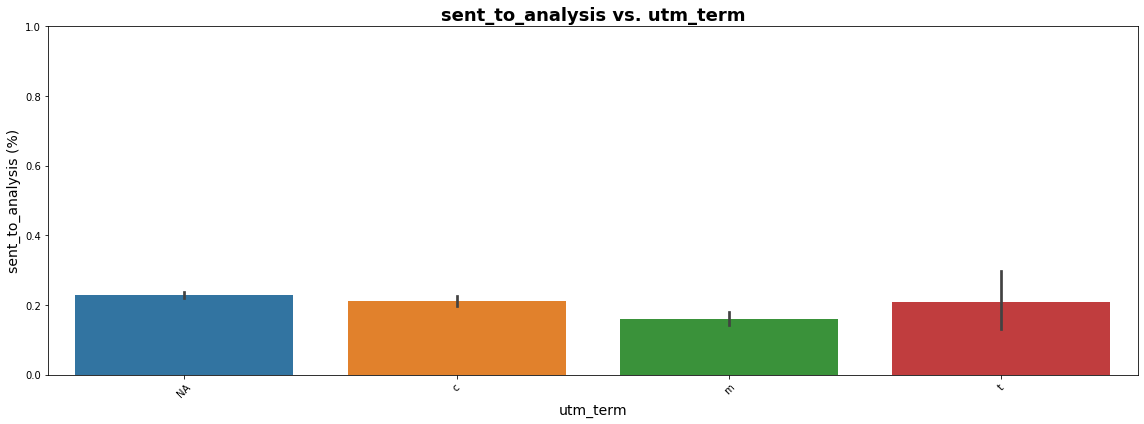

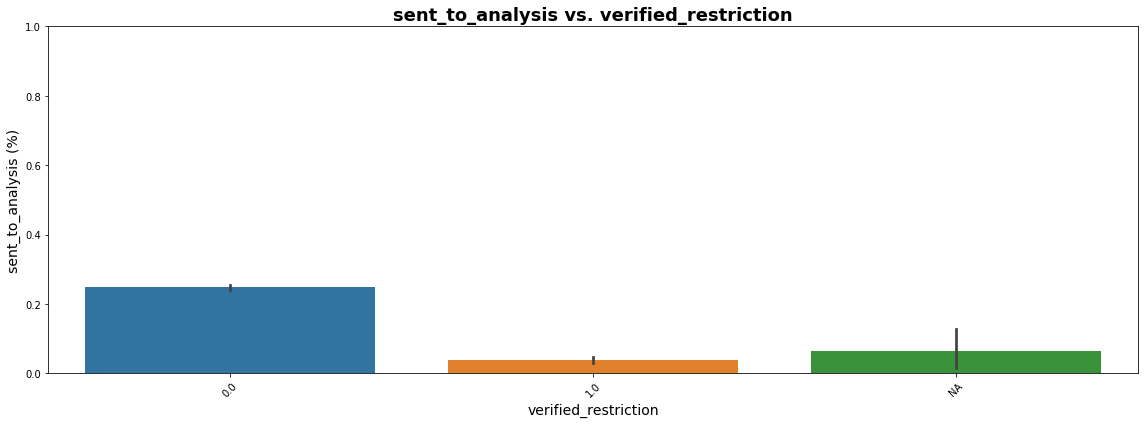

In [19]:
categorical_variables = [
    "auto_brand",
    "auto_year",
    "banking_debts",
    "channel",
    "commercial_debts",
    "dishonored_checks",
    "education_level",
    "expired_debts",
    "form_completed",
    "gender",
    "informed_restriction",
    "landing_page_product",
    "marital_status",
    "protests",
    "state",
    "utm_term",
    "verified_restriction"
]

target = "sent_to_analysis"

for x in categorical_variables:
    bar_plot(data = df_pre_approv, x = x, y = target, title = target + " vs. " + x)

Por meio da análise dos gráficos de barras, é possível observar que:
- `auto_brand`, `auto_year`, `channel`, `education_level`, `landing_page_product` e `state` sugerem a ideia de que, entre as diferentes categorias dessas variáveis, há uma variação das probabilidades dos clientes serem enviados para análise. Entretanto, as barras de erro indicam que, principalmente para `auto_brand` e `auto_year`, há uma diferença significativa no grau de incerteza entre suas categorias. 
- `banking_debts`, `commercial_debts`, `dishonored_checks`, `expired_debts`, `informed_restriction`, `protest` e `verified_restriction` sugerem que clientes com algum tipo de dívida prévia ou restrição de crédito têm menor probabilidade de serem enviados para análise.
- `form_completed` sugere que clientes que preenchem a ficha cadastral têm maior probabilidade de serem enviados para análise.
- `gender` e `utm_term` sugerem que não há uma diferença expressiva na probabilidade referente a clientes de diferentes gêneros ou entre aqueles que usam diferentes dispositivos ao fazer a solicitação de empréstimo.
- `marital_status` sugere que os clientes que informam seu estado civil tem uma probabilidade consideravelmente maior de serem enviados para análise.

<a id="140"></id>

## Análise das Variáveis Numéricas

In [20]:
# Apresenta principais estatísticas das variável numéricas
numeric_variables = [
    "age",
    "collateral_debt",
    "collateral_value",
    "loan_amount",
    "monthly_income",
    "monthly_payment"
]

df_pre_approv[numeric_variables].describe()

,age,collateral_debt,collateral_value,loan_amount,monthly_income,monthly_payment
count,14998.000000,9.691000e+03,1.498500e+04,14998.000000,1.499800e+04,1.424800e+04
mean,38.364049,4.375785e+03,4.910987e+04,14669.179083,1.100505e+04,8.509277e+02
std,11.601046,1.033584e+05,9.875933e+05,13961.548932,1.538846e+05,1.821581e+04
min,18.000000,0.000000e+00,0.000000e+00,2500.000000,0.000000e+00,0.000000e+00
25%,30.000000,0.000000e+00,1.700000e+04,6000.000000,2.500000e+03,3.399400e+02
50%,36.000000,0.000000e+00,2.300000e+04,10500.000000,4.000000e+03,5.507000e+02
75%,46.000000,2.000000e+03,3.347400e+04,18900.000000,6.000000e+03,8.386900e+02
max,115.000000,1.010000e+07,1.000000e+08,719000.000000,1.100000e+07,2.163889e+06


Analisando os valores das estatísticas principais das variáveis numéricas, é possível observar a presença de outliers em todas as variáveis numéricas, uma vez que seus valores máximos são consideravelmente maiores que os valores do percentil 75.

<a id="145"></id>

### Análise da Relação Entre Variáveis Numéricas

Os gráficos a seguir apresentam a relação entre as variáveis numéricas, analisadas duas a duas:

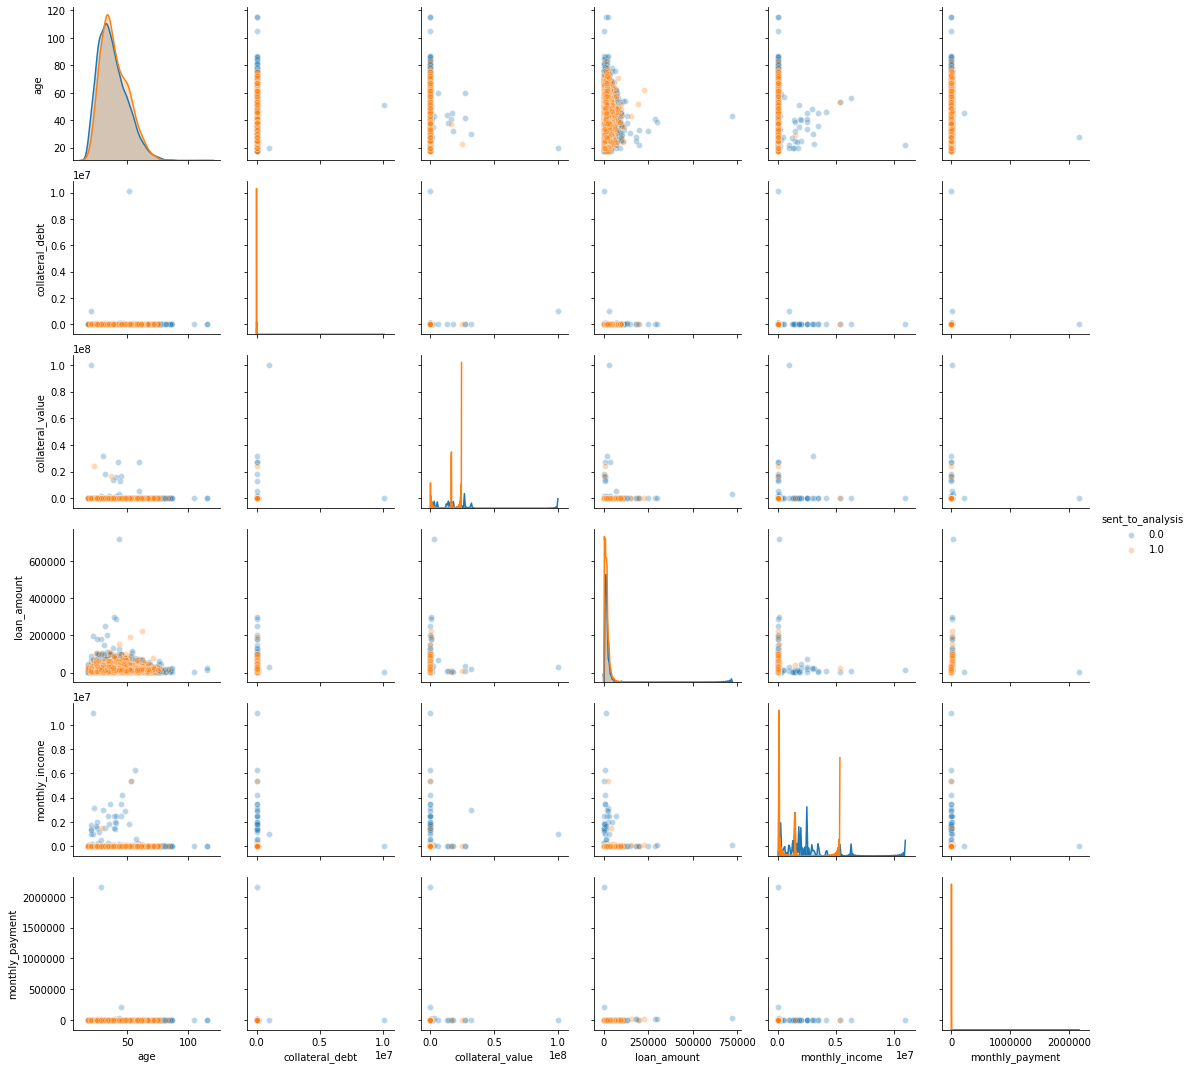

In [21]:
# Plota um grid com gráficos que apresentam a relação das variáveis numéricas duas a duas
sns.pairplot(data = df_pre_approv, 
             vars = numeric_variables, 
             hue = "sent_to_analysis", 
             dropna = True,  
             plot_kws = {'alpha': 0.3})

Os gráficos acima mostram que a maioria dos outliers são referentes à clientes que não foram enviados para análise e não ficou claro nenhum tipo de interação entre as variáveis numéricas.

<a id="149"></id>

### Análise de Outliers

Com o intuito de entender melhor a distribuição das variáveis numéricas, a seguir são apresentados boxplots para cada uma delas. Devido ao fato dos outliers corresponderem a valores muito superiores aos demais, os boxplots foram apresentados também na escala logarítmica.

In [22]:
def boxplot(data, y, title):    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

    sns.boxplot(y = y, data = data, ax = ax[0])
    ax[0].set_ylabel(y, fontsize = 12)
    ax[0].set_title(title, fontsize = 16)
    
    sns.boxplot(y = y, data = data, ax = ax[1])
    ax[1].set_ylabel(y, fontsize = 12)
    ax[1].set_title(title, fontsize = 16)
    ax[1].set_yscale("log")

    plt.tight_layout()
    plt.show()

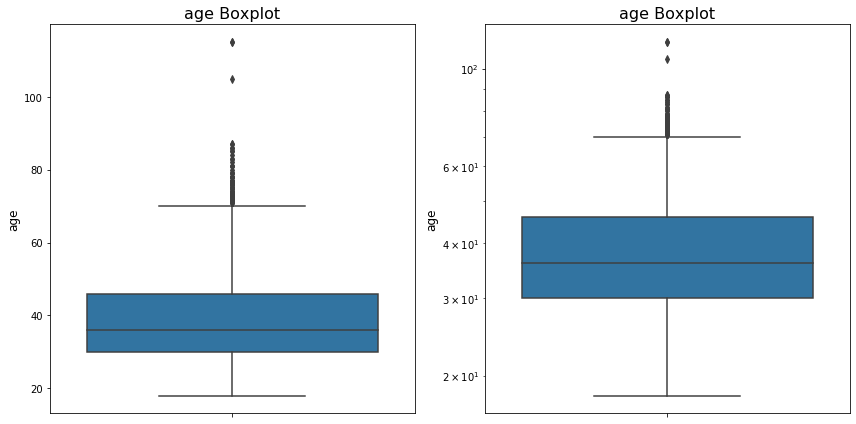

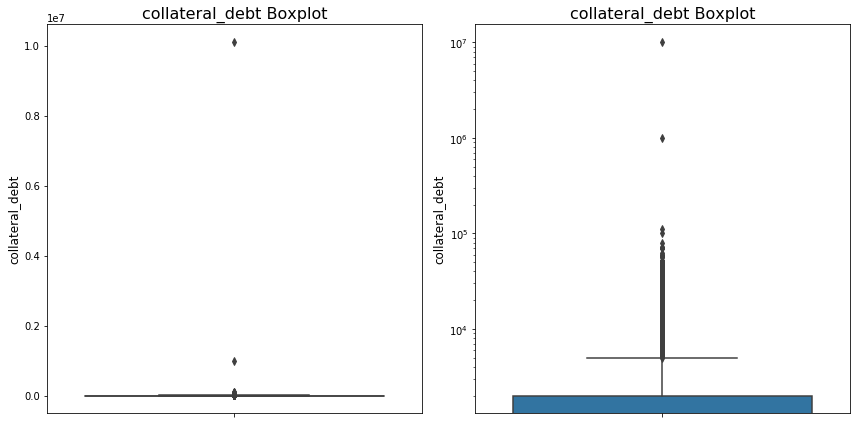

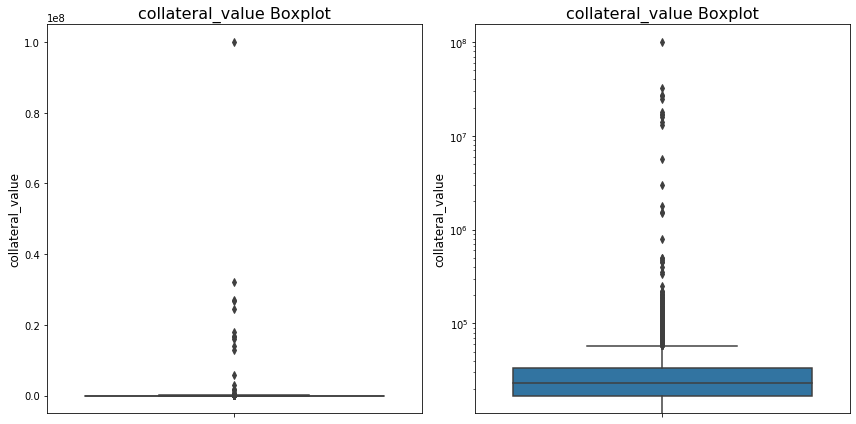

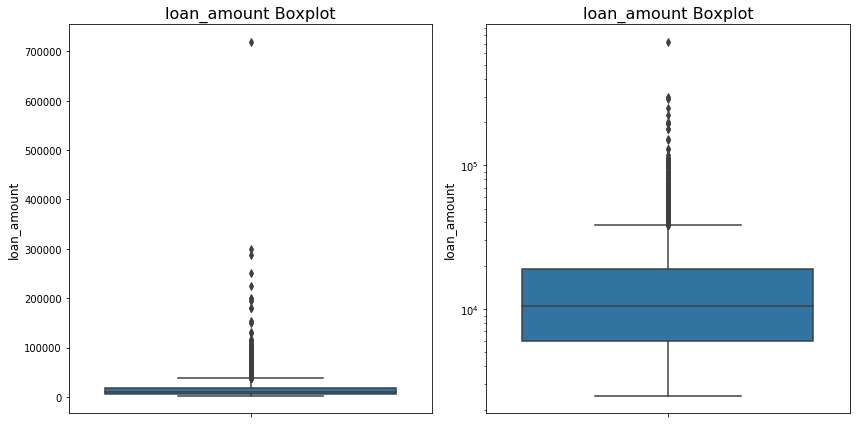

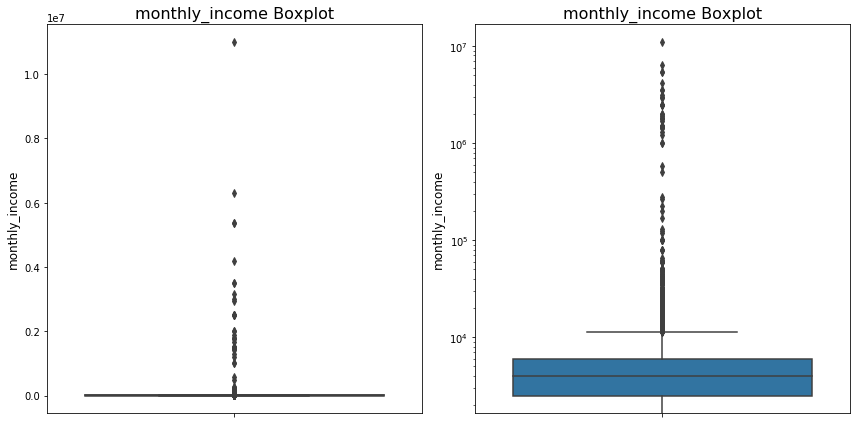

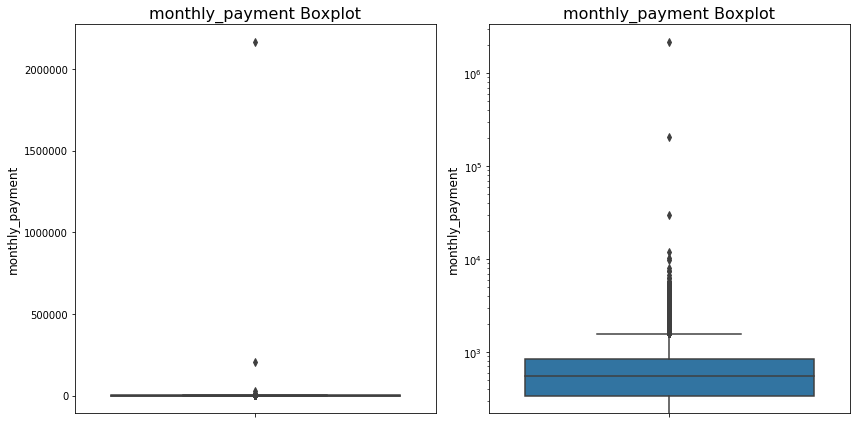

In [23]:
for x in numeric_variables:
    boxplot(data = df_pre_approv, y = x, title = x + " Boxplot")

Por meio dos boxplots, é fácil observar que:
- `age` apresenta valores muito altos, como idades acima de 100 anos, que são aparentemente incoerentes. Isso sugere a ideia de que houve algum problema na entrada desse dados. 
- `collateral_debt`, `collateral_value`, `loan_amount`, `monthly_income` e `monthly_payment` também apresentam valores muito altos, mas várias observações dessas variáveis têm valores iguais a 0, o que faz com que os percentis/quartis principais sejam "puxados" para baixo. 

Com o objetivo de entender esses casos e avaliar como os mesmos devem ser tratados, é válido analisar melhor as observações que têm valores elevados para essas variáveis, avaliando se os mesmos são pertinentes ou não.

In [24]:
# Apresenta valores de algumas observações que tem valores altos de `age`
df_pre_approv[[
    "id",
    "age",
    "auto_brand",
    "auto_model",
    "auto_year",
    "collateral_debt",
    "collateral_value",
    "monthly_income",
    "monthly_payment",
    "loan_amount",
    "sent_to_analysis"
]].sort_values(by = "age", ascending = False).head()

,id,age,auto_brand,auto_model,auto_year,collateral_debt,collateral_value,monthly_income,monthly_payment,loan_amount,sent_to_analysis
31842,117651,115.0,Nissan,Sentra S 2.0/ 2.0 Flex Fuel 16V Aut.,2009,21000.0,30000.0,8000.0,1184.40,27000.00,0.0
31194,119244,115.0,Fiat,Palio ELX 1.0 Fire/30 Anos F. Flex 8V 4p,2008,9000.0,190001.0,1800.0,540.00,12310.03,0.0
2281,170130,105.0,Renault,Clio RN/Alizé/Expr./1.0 Hi-Power 16V 5p,2016,0.0,33000.0,2850.0,541.67,5000.00,0.0
34062,106994,87.0,VW - VolksWagen,SpaceCross I MOTION 1.6 Mi Total Flex 8V,2012,8000.0,45000.0,3500.0,813.67,23936.17,0.0
4437,166760,87.0,Fiat,Siena Celebration 1.0 Fire Flex 8V 4p,2007,NaN,15000.0,3500.0,208.33,5000.00,0.0


Foram observados 3 valores incoerentes para `age`, casos correspondentes a idades acima de 100 anos. Das três observações, o `id 119244`, além de `age`, também apresenta um valor suspeito para a variável `collateral_value`. Já os outros dois casos, parecem ter tido apenas um problema na entrada do dado referente à idade, uma vez que os demais valores parecem ser razoáveis.

In [25]:
# Apresenta valores de algumas observações que tem valores altos de `collateral_debt`
df_pre_approv[[
    "id", 
    "auto_brand",
    "auto_model",
    "auto_year",
    "collateral_debt",
    "collateral_value",
    "monthly_income",
    "monthly_payment",
    "loan_amount",
    "sent_to_analysis"
]].sort_values(by = "collateral_debt", ascending = False).head(10)

,id,auto_brand,auto_model,auto_year,collateral_debt,collateral_value,monthly_income,monthly_payment,loan_amount,sent_to_analysis
29621,126011,GM - Chevrolet,Corsa Sed. Premium 1.4 8V ECONOFLEX 4p,2011,10100000.0,24000.0,1000.0,274.89,5000.00,0.0
28488,129820,Mitsubishi,L200 Triton HPE 3.2 CD TB Int.Diesel Aut,2016,1000000.0,99999999.0,1000000.0,2963.68,29999.70,0.0
18133,145479,GM - Chevrolet,S10 Pic-Up H.Country 2.8 4x4 CD Dies.Aut,2016,111000.0,168000.0,12000.0,647.07,20000.00,0.0
18664,144653,VW - VolksWagen,AMAROK Trendline CD 2.0 TDI 4X4 Dies Aut,2014,100000.0,110000.0,5000.0,161.77,5000.00,0.0
32023,116404,Dodge,JOURNEY RT 3.6 V6 Aut.,2013,80000.0,140000.0,15000.0,339.94,10000.00,0.0
33115,112239,Ford,Ranger XLS 2.5 16V 4x2 CD Flex,2014,72000.0,109000.0,10000.0,2324.79,68389.06,0.0
30120,123535,Ford,Ranger XLS 2.5 16V 4x2 CD Flex,2015,70000.0,88000.0,6302.0,373.93,11000.00,0.0
33444,110818,VW - VolksWagen,TOUAREG 4.2 32V V8 310cv Tiptronic 5p,2008,70000.0,80000.0,10800.0,3158.40,72000.00,0.0
28891,128796,BMW,X3 XDRIVE 35i/M-Sport 3.0 306cv Bi-Turbo,2011,70000.0,145000.0,22000.0,4436.16,130500.00,0.0
32524,114673,Hyundai,Tucson 2.0 16V Flex Aut.,2014,70000.0,79900.0,16000.0,2444.47,71910.00,0.0


Analisando as observações com valores mais altos de `collateral_debt`, foi considerado que apenas os dois primeiros são valores irreais (sendo na casa de milhões de R$), enquanto que os demais, apesar de serem valores altos, são valores aceitáveis, principalmente quando é levado em consideração também os veículos que são dados como garantia nesses casos. 

Ainda com relação aos dois primeiros valores:
- `id 126011`: parece ter tido um problema apenas na entrada do dado `collateral_debt`, uma vez que os demais valores parecem ser razoáveis;
- `id 129820`: além do valor de `collateral_debt`, `collateral_value` e `monthly_income` também são muito elevados.

In [26]:
# Apresenta valores de algumas observações que tem valores altos de `collateral_value`
df_pre_approv[[
    "id", 
    "auto_brand",
    "auto_model",
    "auto_year",
    "collateral_debt",
    "collateral_value",
    "monthly_income",
    "monthly_payment",
    "loan_amount",
    "sent_to_analysis"
]].sort_values(by = "collateral_value", ascending = False).head(30)

,id,auto_brand,auto_model,auto_year,collateral_debt,collateral_value,monthly_income,monthly_payment,loan_amount,sent_to_analysis
28488,129820,Mitsubishi,L200 Triton HPE 3.2 CD TB Int.Diesel Aut,2016,1000000.0,99999999.0,1000000.0,2963.68,29999.70,0.0
27390,131614,Fiat,Strada Working 1.4 mpi Fire Flex 8V CD,2011,5000.0,32000000.0,3000000.0,877.33,20000.00,0.0
33724,107535,Fiat,UNO VIVACE 1.0 EVO Fire Flex 8V 3p,2014,29470.0,27000000.0,2671.0,339.94,10000.00,0.0
28643,129583,Citroën,Xsara Picasso Exclusive 2.0 16V Aut,2010,0.0,26900000.0,5600.0,1301.88,38297.87,0.0
5505,165148,Peugeot,307 Soleil/ Presence 1.6/1.6 Flex 16V 5p,2010,0.0,24500000.0,4000.0,666.67,10000.00,1.0
22436,138922,VW - VolksWagen,Kombi Lotação 1.4 Mi Total Flex 8V,2007,0.0,18000000.0,1200.0,344.33,5000.00,0.0
14798,150682,Fiat,Palio ELX 1.0 Fire/30 Anos F. Flex 8V 4p,2010,NaN,17000000.0,1450.0,43.50,10000.00,0.0
27601,131244,GM - Chevrolet,Corsa Sed. Maxx 1.8 MPFI 8V FlexPower,2005,NaN,16500000.0,4000.0,169.97,5000.00,1.0
2905,169209,Honda,Fit LX 1.4/ 1.4 Flex 8V/16V 5p Mec.,2007,NaN,16000744.0,2000.0,291.67,7000.00,0.0
22992,138083,Fiat,Palio EX 1.0 mpi Fire/ Fire Flex 8v 2p,2005,NaN,14000000.0,1800.0,494.80,9000.00,0.0


Já analisando as observações com valores altos de `collateral_value`, foram encontrados muito mais casos de valores suspeitos (um total de 16 casos com valores na casa de milhões de R$). Como já era esperado, o `id 129820` fica em evidência mais uma vez, e aparece também o `id 131614`, que além do `collateral_value`, apresenta um valor muito elevado de `monthly_income`.

Observou-se também casos em que veículos de montadoras mais 'populares' - como Hyunday, Honda e Fiat - apresentam `collateral_value` numa faixa muito acima da sua categoria, tornado-os duvidosos.

In [27]:
# Apresenta valores de algumas observações que tem valores altos de `loan_amount`
df_pre_approv[[
    "id", 
    "auto_brand",
    "auto_model",
    "auto_year",
    "collateral_debt",
    "collateral_value",
    "monthly_income",
    "monthly_payment",
    "loan_amount",
    "sent_to_analysis"
]].sort_values(by = "loan_amount", ascending = False).head()

,id,auto_brand,auto_model,auto_year,collateral_debt,collateral_value,monthly_income,monthly_payment,loan_amount,sent_to_analysis
18207,145368,Ferrari,California 3.9 Turbo F1 V8 560cv,2016,NaN,3000000.0,100000.0,29958.33,719000.0,0.0
27935,130714,Land Rover,Range Rover Sport HSE 3.0 SDV6 Diesel,2014,0.0,338000.0,100000.0,10198.06,300000.0,0.0
2814,169345,Land Rover,Range Rover Sport HSE 3.0 SDV6 Diesel,2015,0.0,450000.0,40000.0,12000.00,288000.0,0.0
16033,148714,BMW,118iA 2.0 16V 136cv 5p,2011,0.0,56601.0,15000.0,NaN,250000.0,0.0
20314,142197,Land Rover,Range R. EVO DYNAMIQUE BLACK 2.0 Aut. 5p,2015,NaN,250000.0,60000.0,9879.84,225000.0,1.0


Com base nos valores mais altos de `loan_amount`, considerou-se que eles são razóaveis, principalmente quando também é levado em consideração os veículos que são dados como garantia.

In [28]:
# Apresenta valores de algumas observações que tem valores altos de `monthly_income`
df_pre_approv[[
    "id", 
    "auto_brand",
    "auto_model",
    "auto_year",
    "collateral_debt",
    "collateral_value",
    "monthly_income",
    "monthly_payment",
    "loan_amount",
    "sent_to_analysis"
]].sort_values(by = "monthly_income", ascending = False).head(40)

,id,auto_brand,auto_model,auto_year,collateral_debt,collateral_value,monthly_income,monthly_payment,loan_amount,sent_to_analysis
3320,168545,Fiat,Palio ELX 1.0 Fire/30 Anos F. Flex 8V 4p,2007,0.0,15000.0,11000000.0,562.50,13500.0,0.0
10675,156954,VW - VolksWagen,Gol City (Trend) 1.0 Mi Total Flex 8V 4p,2009,0.0,12000.0,6312000.0,450.00,10800.0,0.0
21470,140415,GM - Chevrolet,Corsa Sed. Premium 1.4 8V ECONOFLEX 4p,2009,0.0,25000.0,5360000.0,169.97,5000.0,0.0
22355,139032,GM - Chevrolet,Corsa Sed. Premium 1.4 8V ECONOFLEX 4p,2009,0.0,25000.0,5360000.0,764.85,22500.0,1.0
2052,170448,Fiat,Palio 1.0/ Trofeo 1.0 Fire/ Fire Flex 2p,2007,2000.0,12000.0,4200000.0,450.00,10800.0,0.0
12414,154305,Toyota,ETIOS XLS 1.5 Flex 16V 5p Mec.,2015,1700.0,45000.0,3500000.0,559.13,10000.0,0.0
48,173402,Audi,A1 Sport 1.4 TFSI 185cv 3p S-tronic,2013,0.0,22000.0,3500000.0,194.12,6000.0,0.0
26254,133291,VW - VolksWagen,Golf 1.6Mi/ 1.6Mi Gener./Black & Silver,2005,0.0,25000.0,3150000.0,764.85,22500.0,0.0
27390,131614,Fiat,Strada Working 1.4 mpi Fire Flex 8V CD,2011,5000.0,32000000.0,3000000.0,877.33,20000.0,0.0
33445,110815,VW - VolksWagen,Gol (novo) 1.6 Power/Highi T.Flex 8v 4P,2011,16300.0,27000.0,2930000.0,1065.96,24300.0,0.0


Foram encontrados muito mais casos suspeitos de `monthly_income`. Chama a atenção o fato de que na maioria desses casos, apesar da renda mensal ser extremamente elevada, os veículos dados como garantia são de modelos populares.

In [29]:
# Apresenta valores de algumas observações que tem valores altos de `monthly_payment`
df_pre_approv[[
    "id", 
    "auto_brand",
    "auto_model",
    "auto_year",
    "collateral_debt",
    "collateral_value",
    "monthly_income",
    "monthly_payment",
    "loan_amount",
    "sent_to_analysis"
]].sort_values(by = "monthly_payment", ascending = False).head()

,id,auto_brand,auto_model,auto_year,collateral_debt,collateral_value,monthly_income,monthly_payment,loan_amount,sent_to_analysis
4728,166301,SHINERAY,SY1020 T 22 TRUCKS CD,2012,500.0,8000.0,1180.0,2163888.89,5000.0,0.0
15722,149182,Fiat,Palio 1.0/ Trofeo 1.0 Fire/ Fire Flex 4p,2005,NaN,15000.0,1350.0,208333.33,5000.0,0.0
18207,145368,Ferrari,California 3.9 Turbo F1 V8 560cv,2016,NaN,3000000.0,100000.0,29958.33,719000.0,0.0
2814,169345,Land Rover,Range Rover Sport HSE 3.0 SDV6 Diesel,2015,0.0,450000.0,40000.0,12000.00,288000.0,0.0
27935,130714,Land Rover,Range Rover Sport HSE 3.0 SDV6 Diesel,2014,0.0,338000.0,100000.0,10198.06,300000.0,0.0


Os dois primeiros casos de `monthly_payment` (`id 166301` e `id 149182`) são extremamente elevados, principalmente quando eles são comparados com as respectivas `monthly_income`. Além disso, observou-se que os mesmos são superiores ao `loan_amount` correspondentes e por isso foram considerados como um problema na entrada de dados. 

Diante da análise dos outliers, foi considerado tratá-los da seguinte forma:
- Exclusão de dados para variáveis específicas que aparentemente tiveram algum problema de input:
    - `age` > 100
    - `collateral_debt` > 1000000
    - `monthly_payment` > `loan_amount`

- Exclusão das observações referentes aos `id`s:
    - 119244: `age` e `collateral_value` incoerentes
    - 129820: `collateral_debt`, `collateral_value` e `monthly_income` incoerentes
    - 131614: `collateral_value` e `monthly_income` incoerentes
    
É importante destacar que optou-se por manter os casos suspeitos referentes a `collateral_value` e `monthly_income`, uma vez que existe um número mais significativo de ocorrências dos mesmos e além disso, a maioria desses casos não seguiu para análise, o que sugere a ideia de que o sistema que já vinha sendo utilizado já penalizava esse tipo de situação.

<a id="150"></id>

## Insights da EDA

Resumidamente, obteve-se os seguintes insights por meio da análise exploratória dos dados referentes aos clientes que foram pré-aprovados para o empréstimo com garantia de automóvel:
- **Valores Faltantes e Cardinalidade:**
    - `loan_term`, `marital_status` e`utm_term` possuem um alto percentual de valores faltantes, sendo eles: 100%, 97% e 68%, respectivamente.
    - Como já era esperado, `city`, `auto_model` e `zip_code` apresentam muitas categorias distintas. Já `informed_purpose` também apresenta cardinalidade alta, porém isso se deve ao fato dos dados terem sido carregados manualmente num campo de texto livre.
  
  
- **Balanceamento dos Dados:**
    - 22% dos clientes foram enviados para análise de crédito, enquanto 78% foram rejeitados.


- **Variáveis Categóricas**
    - `auto_brand`, `auto_year`, `channel`, `education_level`, `landing_page_product` e `state` sugerem a ideia de que, entre as diferentes categorias dessas variáveis, há uma variação das probabilidades dos clientes serem enviados para análise. Entretanto, as barras de erro indicam que, principalmente para `auto_brand` e `auto_year`, há uma diferença significativa no grau de incerteza entre as categorias. 
    - `banking_debts`, `commercial_debts`, `dishonored_checks`, `expired_debts`, `informed_restriction`, `protest` e `verified_restriction` sugerem que clientes com algum tipo de dívida prévia ou restrição de crédito têm menor probabilidade de serem enviados para análise.
    - `form_completed` sugere que clientes que preenchem a ficha cadastral têm maior probabilidade de serem enviados para análise.
    - `gender` e `utm_term` sugerem que não há uma diferença expressiva na probabilidade referente a clientes de diferentes gêneros ou entre aqueles que usam diferentes dispositivos ao fazer a solicitação de empréstimo.
    - `marital_status` sugere que os clientes que informam seu estado civil tem uma probabilidade consideravelmente maior de serem enviados para análise.
 
 
- **Variáveis Numéricas:**
    - `age`, `collateral_debt`, `collateral_value`, `loan_amount`, `monthly_income` e `monthly_payment` apresentaram outliers, sendo a maioria deles referentes à clientes que não foram enviados para análise.
    - Não ficou claro nenhum tipo de interação entre as variáveis numéricas.
    - Diante da análise dos outliers, foi considerado tratá-los da seguinte forma:
        - Exclusão de dados para variáveis específicas que aparentemente tiveram algum problema de input:
            - `age` > 100
            - `collateral_debt` > 1000000
            - `monthly_payment` > `loan_amount`

        - Exclusão das observações referentes aos `id`s:
            - 119244: `age` e `collateral_value` incoerentes
            - 129820: `collateral_debt`, `collateral_value` e `monthly_income` incoerentes
            - 131614: `collateral_value` e `monthly_income` incoerentes

<a id="200"></id>

# Preprocessamento

<a id="210"></id>

## Tratamento de Outliers

Conforme mencionado na EDA, foi decidido remover dados identificados como problema de input. Além disso, ficou definido que as observações com `id`s `119244`, `129820`, e `131614` deveriam ser removidas.

In [30]:
# Seta para NaN valores de `age` maiores que 100, valores de `collateral_debt` maiores que 1e7 e valores de 
# `monthly_payment` maiores que o valor de `loan_amount` correspondente
df_pre_approv.loc[df_pre_approv.age > 100, "age"] = np.NaN
df_pre_approv.loc[df_pre_approv.collateral_debt > 1e7, "collateral_debt"] = np.NaN
df_pre_approv.loc[df_pre_approv.monthly_payment > df_pre_approv.loan_amount, "monthly_payment"] = np.NaN

# Remove observações com mais de uma variável incoerente
bad_ids = [   
    119244, # `age` e `collateral_value` incoerentes
    129820, # `collateral_debt`, `collateral_value`, e `monthly_income` incoerentes
    131614, # `collateral_value` e `monthly_income`    
]

df_pre_approv = df_pre_approv[~df_pre_approv.id.isin(bad_ids)]

<a id="220"></id>

## Seleção de Variáveis

Conforme identificado na EDA, algumas das variáveis categóricas tem cardinalidade muito alta, como `city`, `zip_code`, `auto_model`, e `informed_purpose`. Outras, possuem um grande percentual de valores faltantes, como `marital_status`, `utm_term`, e `loan term` (esta última com 100% de valores faltantes).

Com o objetivo de gerar modelos mais simples, menos sujeitos a overfitting, optou-se por remover essas variáveis – com exceção de `informed_purpose` que será tratada separadamente. Além disso, é importante remover dos dados de treinamento as variáveis `id` e `pre_approved`, assim como separar a variável de interesse, `sent_to_analysis`.

In [31]:
target = "sent_to_analysis"

drop_columns = [
    "id",
    "pre_approved", # Constante, = 1
    target,
    
    # Alto percentual de valores faltantes
    "loan_term", # 100% 
    "marital_status", # 97%
    "utm_term", # 68%

    # Alta cardinalidade
    "auto_model", # 1670
    "city", # 2212
    "zip_code", # 4387

    # Irrelevantes
    "gender"
]

y = df_pre_approv.loc[:, target]
X = df_pre_approv.drop(columns = drop_columns)

<a id="230"></id>

## NLP Aplicado à `informed_purpose`    

Uma das variáveis identificadas na EDA como tendo cardinalidade muito alta foi `informed_purpose`. Entretanto, diferente das variáveis removidas na seção anterior, a cardinalidade elevada desta variável vem do fato de ela ter sido obtida a partir de entrada de dados manual, num campo de texto livre. Uma vez que o motivo do empréstimo pode ter um alto poder preditivo, optou-se por fazer um tratamento diferenciado para obter categorias a partir destes dados.

A abordagem utilizada foi a realização de um pré-processamento simples utilizando as bibliotecas `spacy` e `nltk` para tratar os textos originais, removendo acentos, stopwords, pontuação, e classes gramaticais consideradas irrelevantes, e reduzindo palavras para seus radicais comuns.

In [32]:
nlp_pt = spacy.load("pt_core_news_sm")
stemmer_pt = SnowballStemmer(language='portuguese')

In [33]:
def clean_text(text):
    # Converte todo o texto para apenas caractéres minúsculos
    text = text.lower()
    # Remove acentos
    text = remove_accents(text)
    
    return text

def preprocess_text(text, 
                    min_token_len = 2, 
                    irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'VERB'],
                    nlp = nlp_pt,
                    stemmer = stemmer_pt): 
    """
    Dado text, min_token_len, e irrelevant_pos, faz o preprocessamento do texto
    
    Argumentos:
    text -- (str) texto a ser pré-processado
    min_token_len -- (int) o menor comprimento de token a ser considerado
    irrelevant_pos -- (list) lista as classes gramaticais a serem ignoradas
    
    Retorna: (str) texto pré processado
    """

    text = clean_text(text)

    # Processa o texto usando spacy
    doc = nlp(text)
    
    preprocessed = []
    
    # Remove stop words, pontuação, tokens menores que min_token_len e tokens cuja 
    # classe gramatical identificada é irrelavante para análise
    for token in doc:
        if not token.is_stop and not token.is_punct and len(token) >= min_token_len and token.pos_ not in irrelevant_pos:
            # Armazena o stem do token na variável de saída
            preprocessed.append(stemmer.stem(token.norm_))
            
    return " ".join(preprocessed)

In [34]:
X["informed_purpose_processed"] = X.informed_purpose.astype(str).apply(preprocess_text)

In [35]:
X[["informed_purpose", "informed_purpose_processed"]].head()

,informed_purpose,informed_purpose_processed
7,cobrir cheque especial,chequ especial
11,Pagar dívidas,div
13,Pagamento de Cartão de Crédiito,pagament carta crediit
18,comprar um sitio de 20 tarefas,siti 20 taref
22,pagar dividas,div


In [36]:
X = X.drop(columns = ["informed_purpose"])

A partir dessa versão pré-processada de `informed_purpose`, é possível fazer um tratamento adicional para que esta variável seja utilizada nas predições. Entretanto, antes de prosseguir, foi necessário fazer a separação dos dados de treino, validação, e teste, uma vez que o tratamento dado aos dados de treinamento deve ser diferente dos demais.

<a id="240"></id>

## Train vs.Validation vs. Test Split

In [37]:
def train_validation_test_split(X, y, validation_size = 0.15, test_size = 0.15, random_state = 17):
    """
    Faz o split de um dataframe de variáveis de entrada e os labels correspondentes
    em training, validation, e test sets

    Keyword arguments:
    X -- Dataframe com as observações das variáveis.
    y -- Série de labels correspondents.
    validation_size -- o percentual das observações que devem ser separadas em um validation set
    test_size -- o percentual das observações que devem ser separadas em um test set
    random_state -- random seed.
    """
        
    X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, 
                                                        y, 
                                                        test_size = validation_size + test_size, 
                                                        stratify = y,
                                                        random_state = random_state)
    
    X_validation, X_test, y_validation, y_test = train_test_split(X_test_temp, 
                                                                  y_test_temp, 
                                                                  test_size = test_size / (test_size + validation_size), 
                                                                  stratify = y_test_temp,
                                                                  random_state = random_state)
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [38]:
X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(X, y)

<a id="245"></id>

## NLP Aplicado à `informed_purpose` (Continuado)

Uma vez feito o split dos dados, deu-se continuidade ao tratamento da variável `informed_purpose_processed`. Extraiu-se um vocabulário de todas as palavras que aparecem em cada uma das observações, e em seguida foram desconsideradas as palavras que aparecem em menos de dez observações.

In [39]:
# Cria um vocabulário com as palavras mais comuns identificadas na variável `informed_purpose_processed`
words = [doc.split() for doc in X_train.informed_purpose_processed.tolist()]

# Remove palavras que aparecem em menos de no_below observações `informed_purpose_processed`.
dictionary = corpora.Dictionary(words)
dictionary.filter_extremes(no_below = 10)
print("Tamanho do vocabulário:", len(dictionary))

Tamanho do vocabulário: 167


Em seguida, utilizou-se o `CountVectorizer` para gerar uma matriz de variáveis que indica a presença de cada uma das possíveis palavras na observação. O `CountVectorizer` é treinado nos dados de treinamento, e então aplicado também aos dados de validação e teste. O resultado deste processamento é a adição ao dataset de um conjunto de variáveis one-hot-encoded que indicam a presença ou ausência de cada palavra do vocabulário no motivo informado pelo cliente na solicitação do empréstimo.

In [40]:
# Faz o one-hot-encoding dos termos mais comuns do vocavulário
vectorizer = CountVectorizer(binary = True, vocabulary = dictionary.values())

word_matrix_train = vectorizer.fit_transform(X_train.informed_purpose_processed)
count_vect_df_train = pd.DataFrame(word_matrix_train.toarray(), columns = vectorizer.get_feature_names())
X_train = pd.concat([X_train.reset_index(), count_vect_df_train], axis = 1).drop(columns = ["informed_purpose_processed", "index"])

word_matrix_validation = vectorizer.transform(X_validation.informed_purpose_processed)
count_vect_df_validation = pd.DataFrame(word_matrix_validation.toarray(), columns = vectorizer.get_feature_names())
X_validation = pd.concat([X_validation.reset_index(), count_vect_df_validation], axis = 1).drop(columns = ["informed_purpose_processed", "index"])

word_matrix_test = vectorizer.transform(X_test.informed_purpose_processed)
count_vect_df_test = pd.DataFrame(word_matrix_test.toarray(), columns = vectorizer.get_feature_names())
X_test = pd.concat([X_test.reset_index(), count_vect_df_test], axis = 1).drop(columns = ["informed_purpose_processed", "index"])

<a id="250"></id>

## Variáveis Categóricas - One-hot-enconding

Para garantir que as variáveis categóricas sejam tratadas adequadamente pelos modelos utilizados, foi necessário fazer o one-hot-encoding das mesmas. 

In [41]:
def encode_categories(train_df, validation_df, test_df, variables):
    """
    Faz o one-hot-encoding das variáveis categóricas.

    Keyword arguments:
    train_df -- O dataset de treinamento. Utilizado para fazer o fit dos encoders.
    validation_df -- O dataset de validação.
    test_df -- O dataset de testes.
    variables -- as variáveis que serão codificadas.
    """
    train_oh = pd.get_dummies(train_df, columns = variables, prefix = variables)
    validation_oh = pd.get_dummies(validation_df, columns = variables, prefix = variables)
    test_oh = pd.get_dummies(test_df, columns = variables, prefix = variables)

    # left join garante que apenas colunas existentes nos dados de treinamento 
    # estarão presentes nos data frames finais
    train_oh, validation_oh = train_oh.align(validation_oh, join = "left", axis = 1, fill_value = 0)
    train_oh, test_oh = train_oh.align(test_oh, join = "left", axis = 1, fill_value = 0)
                    
    train_df = pd.concat([train_df, train_oh], axis = 1).drop(columns = variables)
    validation_df = pd.concat([validation_df, validation_oh], axis = 1).drop(columns = variables)
    test_df = pd.concat([test_df, test_oh], axis = 1).drop(columns = variables)
    
    return train_df.loc[:, ~train_df.columns.duplicated()], validation_df.loc[:, ~validation_df.columns.duplicated()], test_df.loc[:, ~test_df.columns.duplicated()]

In [42]:
X_train, X_validation, X_test = encode_categories(X_train, X_validation, X_test, [
    "auto_brand",
    "auto_year",
    "banking_debts",
    "channel",
    "commercial_debts",
    "dishonored_checks",
    "education_level",
    "expired_debts",
    "form_completed",
    "informed_restriction",
    "landing_page",
    "landing_page_product",
    "protests",
    "state",
    "verified_restriction",
])

<a id="260"></id>

##  Estratégia para Imputação de Valores Faltantes

Conforme observado na EDA, muitas das variáveis possuiam valores faltantes. Embora aquelas com maior quantidade de valores faltantes já tenham sido removidas, ainda é preciso garantir que todos os valores sejam preenchidos para as demais.

Uma vez que as variáveis categóricas foram tratadas com one-hot-encoding, não foi necessário nenhum tratamento adicional para elas. 

Para as demais, foi utilizado um `IterativeImputer`, que faz estimativas dos valores faltantes para uma variável com base nos valores de outras variáveis.

In [43]:
# Para cada observação, imputa valores faltantes para cada variável com base 
# nos valores das três variáveis mais correlacionadas
imputer = IterativeImputer(random_state = 17, 
                           initial_strategy = "median",
                           n_nearest_features = 3)

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_validation = pd.DataFrame(imputer.transform(X_validation), columns = X_validation.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

In [44]:
print("Ao final do pré-processamento, o dataset possui {} variáveis.".format(len(X_train.columns)))
X_train.head()

Ao final do pré-processamento, o dataset possui 473 variáveis.


,age,monthly_income,collateral_value,loan_amount,collateral_debt,monthly_payment,pagament,div,quitaca,cas,...,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO,verified_restriction_0.0,verified_restriction_1.0,verified_restriction_NA
0,37.0,4000.0,15000.0,13500.0,2642.990727,507.03,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,45.0,4000.0,21000.0,5000.0,2642.990727,541.67,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,24.0,2350.0,9000.0,8100.0,8600.000000,355.32,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,35.0,4000.0,18000.0,10000.0,2642.990727,666.67,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,40.0,6000.0,29000.0,10000.0,16000.000000,416.67,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<a id="300"></id>

# Modelagem

Uma vez que o problema em questão consiste em uma classificação binária, onde a saída deve ser a probabilidade de cada observação pertencer à classe de interesse, os modelos a serem considerados devem ser capazes de estimar uma probabilidade. Além disso, os modelos devem ser capazes de lidar com o desbalanceamento dos dados. De todos os possíveis modelos que atendem a estas características, os avaliados foram:

- Regressão Logística
- Decision Tree
- Random Forest
- XGBoost

<a id="310"></id>

## Baseline Model - Dummy Classifier

Como um baseline, foi treinado um `DummyClassifier` que sempre prevê que o cliente *não* será enviado para análise, dado que este é o caso mais frequente.

In [45]:
baseline_model = DummyClassifier(strategy = "most_frequent")
baseline_model.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [46]:
print("Validation accuracy:", accuracy_score(y_validation, baseline_model.predict(X_validation)))

Validation accuracy: 0.7821253890618053


Devido ao desbalanceamento dos dados, um modelo que escolha sempre a classe mais frequente tem precisão de 78%. Neste caso, fica claro que esta não é uma métrica útil, uma vez que este modelo jamais pode prever que um cliente será enviado para análise.

Portanto, foi preciso definir um critério de avaliação mais adequado.

<a id="320"></id>

## Métrica de Avaliação

A métrica de avaliação para o problema em questão deve atender a dois critérios: ela deve ser calculada a partir de estimativas de probabilidade, e ela deve levar em conta o desbalanceamento dos dados. Assim, uma escolha adequada é a Área sob a Curva ROC (AUROC), utilizando média ponderada.

In [47]:
def report_score(model, X_train, X_validation, y_train, y_validation):
    """
    Dado um modelo e entradas e saídas desejadas, imprime a performance do mesmo 
    calculada usando a área sob a curve ROC (AUROC).

    Keyword arguments:
    model -- o modelo a ser avaliado. Deve suportar predict_proba.
    X_train -- training data (features).
    X_validation -- validation data (features).
    y_train -- training targets.
    y_validation -- validation targets.
    """
    
    print("Train ROC AUC score:", compute_roc_auc_score(model, X_train, y_train))
    print("Validation ROC AUC score:", compute_roc_auc_score(model, X_validation, y_validation))
    
def compute_roc_auc_score(model, X, y_true):
    y_hat = model.predict_proba(X)[:, 1]
    
    return roc_auc_score(y_true, y_hat, average = "weighted")

In [48]:
report_score(baseline_model, X_train, X_validation, y_train, y_validation)

Train ROC AUC score: 0.5
Validation ROC AUC score: 0.5


Utilizando uma métrica mais adequada, fica claro que o DummyClassifier tem uma performance ruim, com um AUROC de 0.5.

<a id="330"></id>

## Regressão Logística

Para o modelo de regressão logística, é importante que os dados estejam escalados. Para isso, foi utilizado um `RobustScaler`, que escala as variáveis usando estatísticas robustas a outliers.

In [49]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [50]:
lr_model = LogisticRegression(random_state = 17, 
                              solver = "lbfgs", 
                              C = 1.0, 
                              class_weight = "balanced",
                              max_iter = 10000,
                              n_jobs = -1)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
report_score(lr_model, X_train_scaled, X_validation_scaled, y_train, y_validation)

Train ROC AUC score: 0.8185142479961558
Validation ROC AUC score: 0.7924238029492638


<a id="340"></id>

## Decision Tree

In [52]:
dt_model = DecisionTreeClassifier(max_depth = 6,
                                  class_weight = "balanced",
                                  random_state = 17)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [53]:
report_score(dt_model, X_train, X_validation, y_train, y_validation)

Train ROC AUC score: 0.7825159542881582
Validation ROC AUC score: 0.766341033286538


<a id="350"></id>

## Random Forest

In [54]:
rf_model = RandomForestClassifier(class_weight = "balanced",
                                  min_samples_leaf = 10,
                                  n_jobs = -1,
                                  random_state = 17)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [55]:
report_score(rf_model, X_train, X_validation, y_train, y_validation)

Train ROC AUC score: 0.8558552801973855
Validation ROC AUC score: 0.7980659233562668


<a id="360"></id>

## XGBoost

In [56]:
xgb_model = XGBClassifier(scale_pos_weight = y_train[y_train == 0].count() / y_train[y_train == 1].count(),
                          random_state = 17,
                          n_jobs = -1)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5874125874125875,
              seed=None, silent=None, subsample=1, verbosity=1)

In [57]:
report_score(xgb_model, X_train, X_validation, y_train, y_validation)

Train ROC AUC score: 0.8378333297124415
Validation ROC AUC score: 0.8195101576730748


<a id="370"></id>

## Comparação dos Modelos

Resumidamente, foram obtidos os seguintes valores para a Área sob a Curva ROC para cada um dos modelos, usando o validation set:

In [58]:
# Constrói uma tabela com os scores de cada um dos modelos treinados acima
pd.DataFrame([
    compute_roc_auc_score(lr_model, X_validation_scaled, y_validation),
    compute_roc_auc_score(dt_model, X_validation, y_validation),
    compute_roc_auc_score(rf_model, X_validation, y_validation),              
    compute_roc_auc_score(xgb_model, X_validation, y_validation)
], index = ["Regressão Logística", "Decision Tree", "Random Forest", "XGBoost"], columns = ["AUROC - Validation"])

,AUROC - Validation
Regressão Logística,0.792424
Decision Tree,0.766341
Random Forest,0.798066
XGBoost,0.819510


Dos modelos avaliados acima, o XGBoost obteve a melhor performance no validation set. Além disso, o modelo de Regressão Logística obteve um resultado satisfatório, com baixa variância. Isso sugere que uma combinação destes dois modelos pode levar a um modelo melhor, com maior capacidade de generalização.

Entretanto, existe a possibilidade de alcançar uma performance ainda melhor ao fazer o ajuste dos hiperaparametros do modelo XGBoost.

<a id="380"></id>

## Ajuste de Hiperparâmetros - XGBoost

Para o ajuste dos hiperaparâmetros, foi utilizado `GridSearchCV` para testar diferentes combinações de `n_estimators`, `max_depth` e `min_child_weight`.

In [59]:
xgb_params = {
    "n_estimators": [70, 80, 100, 150, 200],
    "max_depth": [3, 4, 5],
    "min_child_weight": [10, 15, 17, 20, 22, 25]
}

grid_search = GridSearchCV(estimator = xgb_model, 
                           param_grid = xgb_params, 
                           cv = 3,
                           scoring = "roc_auc_ovr_weighted",
                           n_jobs = -1,
                           verbose = 10)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Os melhores parâmetros obtidos foram: 

`{'max_depth': 3, 'min_child_weight': 22, 'n_estimators': 150}`

In [60]:
optimized_xgb_model = XGBClassifier(n_estimators = 150,
                                    max_depth = 3,
                                    scale_pos_weight = y_train[y_train == 0].count() / y_train[y_train == 1].count(),
                                    min_child_weight = 22,
                                    random_state = 17,
                                    n_jobs = -1)

optimized_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=22, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5874125874125875,
              seed=None, silent=None, subsample=1, verbosity=1)

In [61]:
report_score(optimized_xgb_model, X_train, X_validation, y_train, y_validation)

Train ROC AUC score: 0.8431244110726018
Validation ROC AUC score: 0.819435903980694


Ao contrário do esperado, após o ajuste dos hiperparâmetros, não foi possível obter uma performance melhor que a anterior. Isso provavelmente se deve ao fato do espaço de busca utilizado ter sido pequeno, uma vez que o tempo necessário para testar todas as combinações com um número maior de possíveis valores seria inviável para a conclusão desta análise dentro do prazo. Uma vez que o modelo com os parâmetros padrão já tinha obtido uma boa performance, optou-se por seguir com ele.

Entretanto, conforme mencionado anteriormente, ainda há margem para melhoria, combinando o modelo XGBoost com o modelo de Regressão Logística.

<a id="390"></id>

## Modelo Final - Stacking Ensemble Classifier

Como modelo final, foi treinado um ensemble que faz o stacking do modelo XGBoost com o modelo de Regressão Logística. O objetivo é combinar as predições de ambos os modelos, de forma a tentar utilizar as melhores características de cada um. Optou-se pelo modelo de Regressão Logística por ser o único dos modelos avaliados que não é baseado em decision trees, aliado à sua baixa variância, o que pode contribuir para a capacidade de generalização do modelo final.

In [62]:
estimators = [
     ('xgb', xgb_model),
     ('lr', make_pipeline(RobustScaler(), lr_model))
]

stacking_model = StackingClassifier(estimators = estimators, 
                                    final_estimator = LogisticRegression(),
                                    n_jobs = -1)

stacking_model.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=17, reg_alpha=0,
                                              reg_lambda=1,
                                              scal...
                       

In [63]:
report_score(stacking_model, X_train, X_validation, y_train, y_validation)

Train ROC AUC score: 0.8397469443933261
Validation ROC AUC score: 0.8202631365223748


Este modelo tem performance levemente superior a ambos os modelos individuais (Regressão Logística e XGBoost) treinados anteriormente, e será usado para fazer as previsões finais com o test set.

<a id="400"></id>

# Avaliação e Interpretabilidade do Modelo Final

<a id="410"></id>

## Performance

Conforme mencionado anteriormente, o modelo combinado obteve melhor performance com os dados de validação. Uma vez que os dados de teste não foram utilizados até este momento em nenhuma das etapas de treinamento ou seleção dos modelos, eles podem ser utilizados para obter uma boa estimativa de como o modelo final irá performar com dados nuca antes vistos.

In [64]:
# Faz previsões no test set e reporta o score correspondente
y_hat_test_proba = stacking_model.predict_proba(X_test)[:, 1]
print("Test ROC AUC score:", roc_auc_score(y_test, y_hat_test_proba, average = "weighted"))

Test ROC AUC score: 0.8110815601810416


O valor obtido foi muito próximo do obtido anteriormente para o conjunto de dados de validação, o que indica que não houve overfitting.

Pode-se visualizar a performance do modelo de forma gráfica a partir da sua curva ROC, que ilustra o tradeoff entre  as taxas de positivos reais (*True Positive Rate*) e falsos positivos (*False Positive Rate*), a medida que se varia o limiar de discriminação do modelo (i.e. o limiar de probabilidade para o qual uma estimativa pertence à classe positiva – `sent_to_analysis` = 1).

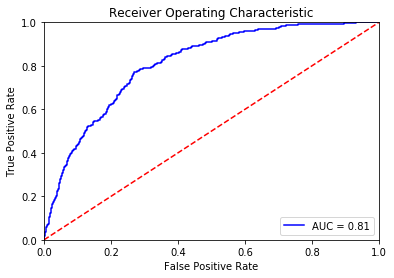

In [65]:
# Plota a curva ROC referente ao test set
fpr, tpr, threshold = roc_curve(y_test, y_hat_test_proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id="420"></id>

## Importância das Variáveis

Pode-se ter uma ideia da importância de cada variável para a performance do modelo plotando separadamente gráficos de importância para ambos os modelos que compoem o modelo final. Para o `XGBoost`, a importância das features pode ser vista abaixo, utilizando o critério `"gain"`, que indica a contribuição de cada variável para o modelo. Uma variável com valor mais alto quando comparado com o de uma outra variável indica que a primeira tem uma importancia maior do que a segunda para gerar uma predição.

Conforme pode-se ver abaixo, algumas variáveis que são intuitivamente importantes também são consideradas importantes para as predições do modelo, como por exemplo `verified_restriction`, que indica existência de restrições de crédito associadas ao cliente, e `collateral_debt`, que indica o valor da dívida remanescente no financiamento do veículo dado como garantia.

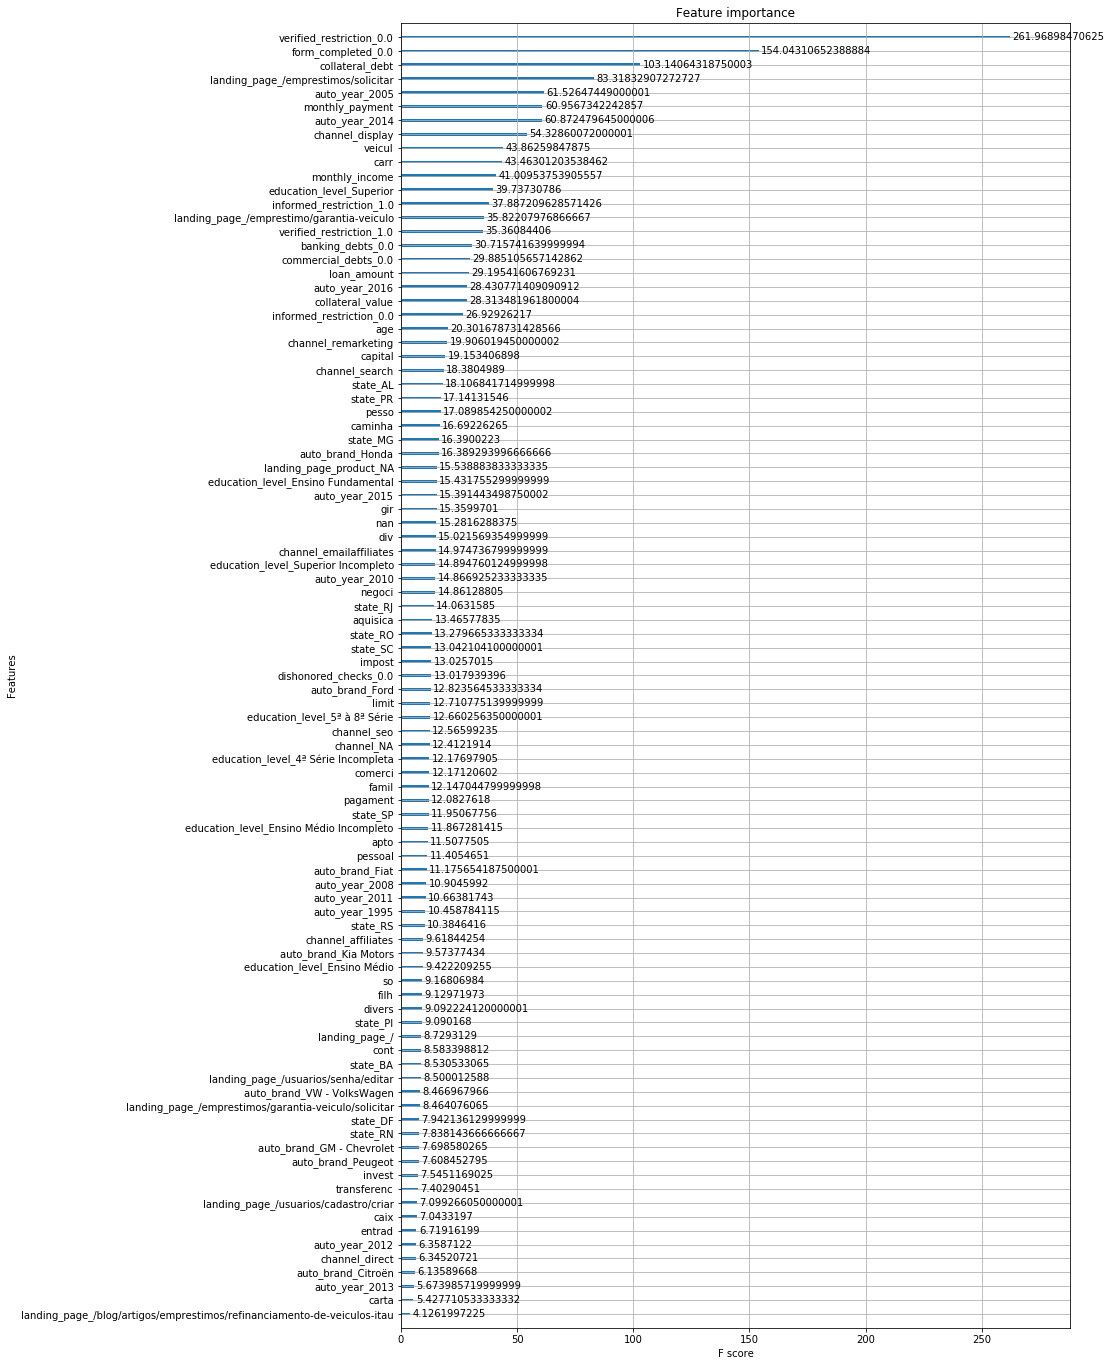

In [66]:
# Plota a importância das features segundo critério `gain`
fig, ax = plt.subplots(1,1, figsize = (12, 24))
plot_importance(stacking_model.named_estimators["xgb"], ax = ax, importance_type = "gain")

Já para o modelo de regressão logística, a importância das variáveis pode ser interpretada a partir do valor do coeficiente associado. Neste caso, como o modelo foi treinado com dados escalados, a magnitude do coeficiente indica o quanto a variável associada contribui para a resposta, e o sinal indica se essa contribuição é positiva (i.e. no sentido de influenciar a predição na direção de `sent_to_analysis` = 1) ou negativa (`sent_to_analisys` = 0).

In [67]:
# Retorna os coeficientes do modelo de regressão logística associados com cada feature, em ordem decrescente
lr_model_coefs = pd.DataFrame(stacking_model.named_estimators["lr"].steps[1][1].coef_, 
                              columns = X_train.columns, 
                              index = ["Coef"]).T.sort_values(by = "Coef", ascending = False)

Conforme pode-se ver abaixo, algumas variáveis associadas ao motivo do empréstimo, assim como a variável que indica ausência de cheques sem fundo no histórico do cliente (`dishonored_checks_0.0`) tem influência positiva.

In [68]:
lr_model_coefs.head(15)

,Coef
apto,1.326609
segur,1.273723
emergenc,1.222457
auto_brand_Jeep,1.194278
landing_page_/usuarios/solicitacoes,1.184654
limit,1.175663
consert,1.089608
landing_page_/cartoes/credito/bgn/cartao-balaroti,1.088516
impost,1.084147
duv,1.073336


Por outro lado o coeficiente associado a variável `landing_page_/blog/artigos/emprestimos/emprestimo-pessoal-sem-consulta-do-cpf-spc-serasa` que mostra a primeira página que o cliente acessou no site, sugere que clientes que estejam particularmente interassados em empréstimos sem consulta de cpf tendem a ser penalizados pelo modelo.

In [69]:
lr_model_coefs.tail(15)

,Coef
abertur,-0.862599
auto_year_2005,-0.876019
education_level_Analfabeto,-0.882932
ja,-0.908666
state_RO,-0.915992
restant,-0.957706
dishonored_checks_1.0,-0.999128
auto_year_1994,-1.035198
landing_page_product_Cards,-1.076564
landing_page_/blog/artigos/emprestimos/emprestimo-pessoal-sem-consulta-do-cpf-spc-serasa,-1.083808


<a id="500"></id>

# Considerações Finais

Uma vez que o modelo desenvolvido estima a probabilidade de um cliente ser enviado para análise de crédito, ele pode ser utilizado diretamente para o fim de priorização de atendimento, permitindo que o os clientes que tem probabilidade mais alta de serem aceitos sejam atendidos primeiro.

Como pôde-se ver na seção anterior, o modelo leva em conta na sua estimativa variáveis que são intuitivamente importantes na aprovação ou não de um cliente. Isto sugere que o modelo está alinhado com a decisão que se esperaria de um humano no mesmo problema, mas sendo ao mesmo tempo capaz de analisar muitas outras variáveis cujo efeito na predição não seja tão claro.

Por fim, a performance obtida pelo modelo, segundo a métrica da Área sob a Curva ROC é bastante satisfatória, especialmente quando considerado que as estimativas não serão utilizadas diretamente para determinar se um cliente será enviado a análise de crédito ou não. Isto é, durante o atendimento com o consultor, ainda existirá a oportunidade para corrigir eventuais falsos positivos – clientes que tenham sido identificados com alta probabilidade de seguir para análise de crédito, mas que deveriam ser recusados.